# Imports

In [ ]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import warnings
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, classification_report
import sklearn.metrics as metr
from sklearn.utils import shuffle
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import svm

In [ ]:
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

# Functions

In [ ]:
def train_test_val_prep(X, y, test_size = 0.3, random_state = 42):
    ### Функция принимает X, y, суммарный размер тестовой и валидационной выборки, и зерно генератора случайных чисел.
    ### Возвращает X и y, стратифицированно разбитые на обучающую, валидационную и тестовую выборки 
    ### в соотношении (1-test_size) : 0.5*test_size : 0.5*test_size
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = test_size, 
    stratify = y, random_state = random_state)
    X_val, X_test, y_val, y_test = train_test_split(
                X_test, y_test, test_size = 0.5, 
                stratify = y_test, random_state = random_state)
    #print('train:val:test - ', '{:.3f}'.format(sum(y_train)/len(y_train)), '{:.3f}'.format(sum(y_val)/len(y_val)), 
         # '{:.3f}'.format(sum(y_test)/len(y_test)))
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def GSCV_report(gs_fitted, X_train, X_test, y_train, y_test):
    ### Функция принимает обученный GridSearchCV, X_train, X_test, y_train и y_test
    ### Выводит метрики на тренировочной и тестовой выборках: 
    ### ROC-AUC, F1-score, Precision, Recall и гиперпараметры лучшей модели, подобранные на кросс-валидации
    y_train_predict_proba = gs_fitted.predict_proba(X_train)
    y_test_predict_proba  = gs_fitted.predict_proba(X_test)
    y_train_predict = gs_fitted.predict(X_train)
    y_test_predict  = gs_fitted.predict(X_test)
    mean_cv_а1     = gs_fitted.best_score_
    train_roc       = roc_auc_score(y_train, y_train_predict_proba[:, 1])
    train_f1        = f1_score(y_train, y_train_predict)
    test_roc        = roc_auc_score(y_test, y_test_predict_proba[:, 1])
    test_f1        = f1_score(y_test, y_test_predict)
    train_precision = precision_score(y_train, y_train_predict)
    train_recall = recall_score(y_train, y_train_predict) 
    test_precision = precision_score(y_test, y_test_predict)
    test_recall = recall_score(y_test, y_test_predict) 
    best_params     = gs_fitted.best_params_

    # Print results
    print('*'*10, 'GRID SEARCH RESULTS', '*'*10)
    print('- Mean CV F1:\t{:.3f}'.format(mean_cv_а1))
    print('----------- \t Train--Val')
    print('- ROC-AUC:  \t{:.3f}, {:.3f}'.format(train_roc, test_roc))
    print('- F1:       \t{:.3f}, {:.3f}'.format(train_f1, test_f1))
    print('- Precision:\t{:.3f}, {:.3f}'.format(train_precision, test_precision))
    print('- Recall:   \t{:.3f}, {:.3f}'.format(train_recall, test_recall))
    print('- Best hyperparameters', best_params)
    print('**'*21)
    print('')

In [ ]:
def GSCV_report_class(gs_fitted, X_train, X_test, y_train, y_test):
    ### Функция принимает обученный GridSearchCV, X_train, X_test, y_train и y_test
    ### Выводит стандарный classification_report из sklearn на тренировочной и тестовой выборках: 
    y_train_predict_proba = gs_fitted.predict_proba(X_train)
    y_test_predict_proba  = gs_fitted.predict_proba(X_test)
    y_train_predict = gs_fitted.predict(X_train)
    y_test_predict  = gs_fitted.predict(X_test)
    print('Train report')
    print(classification_report(y_train, y_train_predict))
    print('Validation report')
    print(classification_report(y_test, y_test_predict))

In [ ]:
def gridsearchCV_universal(X_t, X_v, y_t, y_v, estimator, scoring, estimator_hyprms, n_splits):
    ### Функция принимает X_train, X_test, y_train, y_test, а также модель, 
    ### которую надо оптимозировать, ее гиперпараметры в виде словаря и количество разбиений на кросс-валидации
    ### Модель включается в пайплайн, в котором на каждом фолде кросс-валидации сначала происходит мин-макс 
    ### скалирование, а затем обучение модели. 
    ### Модель возвращает обученный объект GridSearchCV
    skf = StratifiedKFold(n_splits=n_splits)
    cv = skf.split(X_t, y_t)
    # Grid search
    estimator_pipeline = Pipeline([('scaler', MinMaxScaler()), ('estimator', estimator)])
    gs = GridSearchCV(
            estimator    = estimator_pipeline,
            param_grid   = estimator_hyprms,
            cv           = cv,
            scoring      = scoring,
            n_jobs       = 4
    )
    
    # Fit and evaluate the estimator
    gs.fit(X_t, y_t)
    #GSCV_report(gs, X_t, X_v, y_t, y_v)
    return gs

In [ ]:
def gridsearchCV_SVM(X_t, X_v, y_t, y_v, estimator, scoring, estimator_hyprms, n_splits):
    ### Функция принимает X_train, X_test, y_train, y_test, а также модель, 
    ### которую надо оптимозировать, ее гиперпараметры в виде словаря и количество разбиений на кросс-валидации
    ### Для SVM сначала производится скалирование на всем тренировочном датасете, а затем оптимизация модели
    ### Модель возвращает обученный объект GridSearchCV
    skf = StratifiedKFold(n_splits=n_splits)
    cv = skf.split(X_t, y_t)
    scaler = MinMaxScaler()
    scaler.fit(X_t)
    X_t = scaler.transform(X_t)
    X_v = scaler.transform(X_v)
    # Grid search
    gs = GridSearchCV(
            estimator    = estimator,
            param_grid   = estimator_hyprms,
            cv           = cv,
            scoring      = scoring,
            n_jobs       = 4
    )
    
    # Fit and evaluate the estimator
    gs.fit(X_t, y_t)
    #GSCV_report(gs, X_t, X_v, y_t, y_v)
    return gs

# Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Set1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set1.csv', index_col=0)
Set2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set2.csv', index_col=0)
Set3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set3.csv', index_col=0)
Set4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set4.csv', index_col=0)
Set5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set5.csv', index_col=0)
Set6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set6.csv', index_col=0)
Set7 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set7.csv', index_col=0)
Set8 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set8.csv', index_col=0)
Set9 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set9.csv', index_col=0)

In [ ]:
Datasets_Dict = {"Set1":Set1,
                "Set2":Set2,
                'Set3':Set3,
                "Set4":Set4,
                "Set5":Set5,
                "Set6":Set6,
                "Set7":Set7,
                'Set8':Set8,
                'Set9':Set9}

In [ ]:
Set1

,0,1,2,3,4,5,6,7,8,9,...,Grid_Score_7cb7,Grid_Score_7mpb,Grid_Score_7mhp,Grid_Score_7vh8,Grid_Score_7rc0,Mw,logP,Percent,Experiment_rank,Experiment_label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-37.316181,-30.805252,-31.948048,-36.003437,-27.870602,377.440,3.138292,24.88,966,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-34.852295,-31.238728,-27.943371,-35.349831,-33.367020,286.331,1.022024,20.97,1476,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-34.560555,-34.023727,-30.177105,-35.462032,-33.423267,244.203,-2.415242,31.53,477,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-30.326897,-31.173742,-28.237204,-30.232658,-31.082962,238.370,2.263478,11.46,3739,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-36.932201,-42.139709,-41.349922,-39.431709,-38.675064,380.490,1.953302,-2.56,6548,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-45.560795,-40.692627,-45.211800,-43.341118,-44.733994,421.910,5.003479,20.87,1487,0
6728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-41.931141,-46.609779,-43.989006,-48.202469,-47.242767,427.450,0.288359,4.46,5476,0
6729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-38.844261,-35.831299,-35.069622,-36.915371,-35.920124,291.267,-1.422364,14.22,2957,0
6730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-46.475452,-42.751408,-36.070297,-44.013496,-41.348061,351.410,0.967023,13.10,3277,0


# Models optimization on F1-score

Поиск оптимальных гиперпараметров моделей на 9 датасетах с F1-мерой в качестве метрики

### Logistic regression 

In [ ]:
lr_models = {}

In [ ]:
for i in range(1,10):  #можно изменить диапазон, чтобы рассмотреть другие датасеты
    print('Set{}'.format(i))
    dataset = Datasets_Dict['Set{}'.format(i)]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', ], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    
    scoring          = 'f1'
    estimator_name   = 'LogisticRegression'
    estimator        = LogisticRegression(
                             max_iter = 400, class_weight = 'balanced'
                       )
    estimator_hyprms = {
        'estimator__C'       : np.geomspace(1e-6, 1e2, 5),
        'estimator__penalty' : ['l1', 'l2', None]
                        }
    n_splits = 5
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    model = gridsearchCV_universal(X_train_clean, 
                                   X_val_clean, 
                                   y_train, y_val, estimator, scoring, estimator_hyprms, n_splits)
    lr_models['Set{}'.format(i)] = model

Set1
Set2
Set3
Set4
Set5
Set6
Set7
Set8
Set9


In [ ]:
for m in lr_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', ], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    GSCV_report(lr_models[m], X_train_clean, X_val_clean, y_train, y_val)

Set1
********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.069
----------- 	 Train--Val
- ROC-AUC:  	0.703, 0.549
- F1:       	0.091, 0.063
- Precision:	0.048, 0.033
- Recall:   	0.760, 0.531
- Best hyperparameters {'estimator__C': 1e-06, 'estimator__penalty': 'l2'}
******************************************

Set2
********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.064
----------- 	 Train--Val
- ROC-AUC:  	0.761, 0.468
- F1:       	0.122, 0.049
- Precision:	0.067, 0.027
- Recall:   	0.687, 0.281
- Best hyperparameters {'estimator__C': 0.01, 'estimator__penalty': 'l2'}
******************************************

Set3
********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.062
----------- 	 Train--Val
- ROC-AUC:  	0.758, 0.443
- F1:       	0.122, 0.039
- Precision:	0.067, 0.021
- Recall:   	0.693, 0.219
- Best hyperparameters {'estimator__C': 0.01, 'estimator__penalty': 'l2'}
******************************************

Set4
********** GRID SEARCH RESULTS **********
- Mean CV 

In [ ]:
for m in lr_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', ], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    GSCV_report_class(lr_models[m], X_train_clean, X_val_clean, y_train, y_val)

Set1
Train report
              precision    recall  f1-score   support

           0       0.98      0.51      0.67      4562
           1       0.05      0.76      0.09       150

    accuracy                           0.52      4712
   macro avg       0.52      0.63      0.38      4712
weighted avg       0.95      0.52      0.65      4712

Validation report
              precision    recall  f1-score   support

           0       0.97      0.50      0.66       978
           1       0.03      0.53      0.06        32

    accuracy                           0.50      1010
   macro avg       0.50      0.51      0.36      1010
weighted avg       0.94      0.50      0.64      1010

Set2
Train report
              precision    recall  f1-score   support

           0       0.99      0.69      0.81      4562
           1       0.07      0.69      0.12       150

    accuracy                           0.69      4712
   macro avg       0.53      0.69      0.47      4712
weighted avg       0

In [ ]:
lr_models['Set9'].best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('estimator',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=400))])

In [ ]:
best_lr_results_dict = {}
for j in range(1,10):  #можно изменить диапазон, чтобы рассмотреть другие датасеты
    rocaucs_train = []
    rocaucs_test = []
    f1s_train = []
    f1s_test = []
    m = 'Set{}'.format(j)
    model = lr_models[m].best_estimator_
    for i in [0,7,12,42,365,500,653,834,1000]:
        dataset = Datasets_Dict['Set{}'.format(j)]
        y = dataset['Experiment_label']
        X = dataset.drop(['Experiment_label'], axis = 1)
        X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = i)
        
        scoring          = 'f1'
        estimator_name   = m
        X_train_clean = X_train.drop('Chembl_Name', axis=1)
        X_val_clean = X_val.drop('Chembl_Name', axis=1)

        model.fit(X_train_clean,y_train)
        y_train_predict_proba = model.predict_proba(X_train_clean)
        y_test_predict_proba  = model.predict_proba(X_val_clean)
        y_train_predict = model.predict(X_train_clean)
        y_test_predict  = model.predict(X_val_clean)
        rocaucs_train.append(roc_auc_score(y_train, y_train_predict_proba[:, 1]))
        rocaucs_test.append(roc_auc_score(y_val, y_test_predict_proba[:, 1])) 
        f1s_train.append(f1_score(y_train, y_train_predict))
        f1s_test.append(f1_score(y_val, y_test_predict))
    best_lr_results_dict[m] = [np.mean(rocaucs_train), np.std(rocaucs_train), np.mean(rocaucs_test), np.std(rocaucs_test),np.mean(f1s_train), np.std(f1s_train),np.mean(f1s_test), np.std(f1s_test)]
    print('{}, Set{}: \t ROCAUC_train {:.3f} +- {:.3f} \t ROCAUC_val {:.3f} +- {:.3f}'.format(m,j,best_lr_results_dict[m][0], best_lr_results_dict[m][1],best_lr_results_dict[m][2],best_lr_results_dict[m][3]))
    print('{}, Set{}: \t F1_train {:.3f} +- {:.3f} \t F1_val {:.3f} +- {:.3f}'.format(m,j,best_lr_results_dict[m][4], best_lr_results_dict[m][5],best_lr_results_dict[m][6],best_lr_results_dict[m][7]))

Set1, Set1: 	 ROCAUC_train 0.713 +- 0.008 	 ROCAUC_val 0.593 +- 0.056
Set1, Set1: 	 F1_train 0.100 +- 0.011 	 F1_val 0.079 +- 0.014
Set2, Set2: 	 ROCAUC_train 0.766 +- 0.009 	 ROCAUC_val 0.566 +- 0.070
Set2, Set2: 	 F1_train 0.127 +- 0.006 	 F1_val 0.079 +- 0.015
Set3, Set3: 	 ROCAUC_train 0.764 +- 0.009 	 ROCAUC_val 0.548 +- 0.073
Set3, Set3: 	 F1_train 0.126 +- 0.007 	 F1_val 0.069 +- 0.017
Set4, Set4: 	 ROCAUC_train 0.834 +- 0.013 	 ROCAUC_val 0.680 +- 0.043
Set4, Set4: 	 F1_train 0.249 +- 0.016 	 F1_val 0.152 +- 0.028
Set5, Set5: 	 ROCAUC_train 0.958 +- 0.003 	 ROCAUC_val 0.691 +- 0.034
Set5, Set5: 	 F1_train 0.300 +- 0.009 	 F1_val 0.144 +- 0.019
Set6, Set6: 	 ROCAUC_train 0.963 +- 0.002 	 ROCAUC_val 0.692 +- 0.034
Set6, Set6: 	 F1_train 0.314 +- 0.008 	 F1_val 0.149 +- 0.017
Set7, Set7: 	 ROCAUC_train 0.763 +- 0.011 	 ROCAUC_val 0.623 +- 0.048
Set7, Set7: 	 F1_train 0.128 +- 0.007 	 F1_val 0.098 +- 0.015
Set8, Set8: 	 ROCAUC_train 1.000 +- 0.000 	 ROCAUC_val 0.680 +- 0.044
Set8, 

### Random Forest

На всех датасетах считается очень долго!

In [ ]:
rf_models = {}

In [ ]:
for i in range(8,10): #можно изменить диапазон, чтобы рассмотреть другие датасеты
    print('Set{}'.format(i))
    dataset = Datasets_Dict['Set{}'.format(i)]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    
    scoring          = 'f1'
    estimator_name   = 'RF'
    estimator = RandomForestClassifier(n_estimators = 1000, random_state=42, 
                                       criterion = 'gini')
    skf = StratifiedKFold(n_splits=5)
    cv = skf.split(X_train, y_train)
    estimator_hyprms = {
       'estimator__class_weight'   : ['balanced', 'balanced_subsample'],
       'estimator__max_depth'       : [7,10,15],
       'estimator__min_samples_split':[3,5,7,10,15],
       'estimator__min_samples_leaf': [2, 3, 5, 7]#,
       #'estimator__features'        : ['auto','log2', 0.5, 0.8]
    }

    n_splits = 5
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    model = gridsearchCV_universal(X_train_clean, 
                                   X_val_clean, 
                                   y_train, y_val, estimator, scoring, estimator_hyprms, n_splits)
    rf_models['Set{}'.format(i)] = model

Set8
Set9


In [ ]:
for m in rf_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    GSCV_report(rf_models[m], X_train_clean, X_val_clean, y_train, y_val)

Set8
********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.180
----------- 	 Train--Val
- ROC-AUC:  	0.979, 0.806
- F1:       	0.552, 0.293
- Precision:	0.423, 0.240
- Recall:   	0.793, 0.375
- Best hyperparameters {'estimator__class_weight': 'balanced_subsample', 'estimator__max_depth': 7, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 15}
******************************************

Set9
********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.167
----------- 	 Train--Val
- ROC-AUC:  	0.983, 0.798
- F1:       	0.616, 0.222
- Precision:	0.509, 0.200
- Recall:   	0.780, 0.250
- Best hyperparameters {'estimator__class_weight': 'balanced_subsample', 'estimator__max_depth': 7, 'estimator__min_samples_leaf': 7, 'estimator__min_samples_split': 15}
******************************************



In [ ]:
for m in rf_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    GSCV_report_class(rf_models[m], X_train_clean, X_val_clean, y_train, y_val)

Set8
Train report
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      4562
           1       0.42      0.79      0.55       150

    accuracy                           0.96      4712
   macro avg       0.71      0.88      0.77      4712
weighted avg       0.97      0.96      0.96      4712

Validation report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       978
           1       0.24      0.38      0.29        32

    accuracy                           0.94      1010
   macro avg       0.61      0.67      0.63      1010
weighted avg       0.96      0.94      0.95      1010

Set9
Train report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4562
           1       0.51      0.78      0.62       150

    accuracy                           0.97      4712
   macro avg       0.75      0.88      0.80      4712
weighted avg       0

In [ ]:
best_rf_results_dict = {}
for j in range(8,10):  #можно изменить диапазон, чтобы рассмотреть другие датасеты
    rocaucs_train = []
    rocaucs_test = []
    f1s_train = []
    f1s_test = []
    m = 'Set{}'.format(j)
    model = rf_models[m].best_estimator_
    for i in [0,7,12,42,365,500,653,834,1000]:
        dataset = Datasets_Dict['Set{}'.format(j)]
        y = dataset['Experiment_label']
        X = dataset.drop(['Experiment_label','Experiment_rank','Percent'], axis = 1)
        X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = i)
        
        scoring          = 'f1'
        estimator_name   = m
        X_train_clean = X_train.drop('Chembl_Name', axis=1)
        X_val_clean = X_val.drop('Chembl_Name', axis=1)

        model.fit(X_train_clean,y_train)
        y_train_predict_proba = model.predict_proba(X_train_clean)
        y_test_predict_proba  = model.predict_proba(X_val_clean)
        y_train_predict = model.predict(X_train_clean)
        y_test_predict  = model.predict(X_val_clean)
        rocaucs_train.append(roc_auc_score(y_train, y_train_predict_proba[:, 1]))
        rocaucs_test.append(roc_auc_score(y_val, y_test_predict_proba[:, 1])) 
        f1s_train.append(f1_score(y_train, y_train_predict))
        f1s_test.append(f1_score(y_val, y_test_predict))
    best_rf_results_dict[m] = [np.mean(rocaucs_train), np.std(rocaucs_train), np.mean(rocaucs_test), np.std(rocaucs_test),np.mean(f1s_train), np.std(f1s_train),np.mean(f1s_test), np.std(f1s_test)]
    print('{}, Set{}: \t ROCAUC_train {:.3f} +- {:.3f} \t ROCAUC_val {:.3f} +- {:.3f}'.format(m,j,best_rf_results_dict[m][0], best_rf_results_dict[m][1],best_rf_results_dict[m][2],best_rf_results_dict[m][3]))
    print('{}, Set{}: \t F1_train {:.3f} +- {:.3f} \t F1_val {:.3f} +- {:.3f}'.format(m,j,best_rf_results_dict[m][4], best_rf_results_dict[m][5],best_rf_results_dict[m][6],best_rf_results_dict[m][7]))

Set8, Set8: 	 ROCAUC_train 0.969 +- 0.005 	 ROCAUC_val 0.703 +- 0.060
Set8, Set8: 	 F1_train 0.453 +- 0.045 	 F1_val 0.212 +- 0.039
Set9, Set9: 	 ROCAUC_train 0.972 +- 0.006 	 ROCAUC_val 0.699 +- 0.057
Set9, Set9: 	 F1_train 0.499 +- 0.058 	 F1_val 0.208 +- 0.034


### Catboost

In [ ]:
catboost_models = {}

In [ ]:
for i in range(1,10):  #можно изменить диапазон, чтобы рассмотреть другие датасеты
    print('Set{}'.format(i))
    dataset = Datasets_Dict['Set{}'.format(i)]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    
    scoring          = 'f1'
    estimator_name   = 'Cat Boost'
    estimator        = CatBoostClassifier(iterations=70,learning_rate=0.5,verbose=False) 
    estimator_hyprms = {
        'estimator__depth'   : [4,5,6],
        'estimator__l2_leaf_reg': [2,5,10]
        
        }
    skf = StratifiedKFold(n_splits=5)
    cv = skf.split(X_train, y_train)
    n_splits = 5
    
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    model = gridsearchCV_universal(X_train_clean, 
                                   X_val_clean, 
                                   y_train, y_val, estimator, scoring, estimator_hyprms, n_splits)
    catboost_models['Set{}'.format(i)] = model

Set1
Set2
Set3
Set4
Set5
Set6
Set7
Set8
Set9


In [ ]:
for m in catboost_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    GSCV_report(catboost_models[m], X_train_clean, X_val_clean, y_train, y_val)
    GSCV_report_class(catboost_models[m], X_train_clean, X_val_clean, y_train, y_val)

Set1
********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.013
----------- 	 Train--Val
- ROC-AUC:  	1.000, 0.606
- F1:       	0.276, 0.000
- Precision:	1.000, 0.000
- Recall:   	0.160, 0.000
- Best hyperparameters {'estimator__depth': 5, 'estimator__l2_leaf_reg': 2}
******************************************

Train report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4562
           1       1.00      0.16      0.28       150

    accuracy                           0.97      4712
   macro avg       0.99      0.58      0.63      4712
weighted avg       0.97      0.97      0.96      4712

Validation report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       978
           1       0.00      0.00      0.00        32

    accuracy                           0.97      1010
   macro avg       0.48      0.50      0.49      1010
weighted avg       0.94      0.97      0.95      1010


In [ ]:
best_catboost_results_dict = {}
for j in range(1,10):  #можно изменить диапазон, чтобы рассмотреть другие датасеты
    rocaucs_train = []
    rocaucs_test = []
    f1s_train = []
    f1s_test = []
    m = 'Set{}'.format(j)
    model = catboost_models[m].best_estimator_
    for i in [0,7,12,42,365,500,653,834,1000]:
        dataset = Datasets_Dict['Set{}'.format(j)]
        y = dataset['Experiment_label']
        X = dataset.drop(['Experiment_label','Experiment_rank','Percent'], axis = 1)
        X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = i)
        
        scoring          = 'f1'
        estimator_name   = m
        X_train_clean = X_train.drop('Chembl_Name', axis=1)
        X_val_clean = X_val.drop('Chembl_Name', axis=1)

        model.fit(X_train_clean,y_train)
        y_train_predict_proba = model.predict_proba(X_train_clean)
        y_test_predict_proba  = model.predict_proba(X_val_clean)
        y_train_predict = model.predict(X_train_clean)
        y_test_predict  = model.predict(X_val_clean)
        rocaucs_train.append(roc_auc_score(y_train, y_train_predict_proba[:, 1]))
        rocaucs_test.append(roc_auc_score(y_val, y_test_predict_proba[:, 1])) 
        f1s_train.append(f1_score(y_train, y_train_predict))
        f1s_test.append(f1_score(y_val, y_test_predict))
    best_catboost_results_dict[m] = [np.mean(rocaucs_train), np.std(rocaucs_train), np.mean(rocaucs_test), np.std(rocaucs_test),np.mean(f1s_train), np.std(f1s_train),np.mean(f1s_test), np.std(f1s_test)]
    print('{}, Set{}: \t ROCAUC_train {:.3f} +- {:.3f} \t ROCAUC_val {:.3f} +- {:.3f}'.format(m,j,best_catboost_results_dict[m][0], best_catboost_results_dict[m][1],best_catboost_results_dict[m][2],best_catboost_results_dict[m][3]))
    print('{}, Set{}: \t F1_train {:.3f} +- {:.3f} \t F1_val {:.3f} +- {:.3f}'.format(m,j,best_catboost_results_dict[m][4], best_catboost_results_dict[m][5],best_catboost_results_dict[m][6],best_catboost_results_dict[m][7]))

Set1, Set1: 	 ROCAUC_train 1.000 +- 0.000 	 ROCAUC_val 0.563 +- 0.050
Set1, Set1: 	 F1_train 0.247 +- 0.038 	 F1_val 0.000 +- 0.000
Set2, Set2: 	 ROCAUC_train 0.998 +- 0.001 	 ROCAUC_val 0.590 +- 0.040
Set2, Set2: 	 F1_train 0.821 +- 0.031 	 F1_val 0.050 +- 0.041
Set3, Set3: 	 ROCAUC_train 0.930 +- 0.010 	 ROCAUC_val 0.624 +- 0.050
Set3, Set3: 	 F1_train 0.260 +- 0.028 	 F1_val 0.013 +- 0.025
Set4, Set4: 	 ROCAUC_train 1.000 +- 0.000 	 ROCAUC_val 0.655 +- 0.052
Set4, Set4: 	 F1_train 0.897 +- 0.009 	 F1_val 0.095 +- 0.026
Set5, Set5: 	 ROCAUC_train 1.000 +- 0.000 	 ROCAUC_val 0.679 +- 0.067
Set5, Set5: 	 F1_train 0.894 +- 0.016 	 F1_val 0.106 +- 0.051
Set6, Set6: 	 ROCAUC_train 0.986 +- 0.005 	 ROCAUC_val 0.647 +- 0.057
Set6, Set6: 	 F1_train 0.587 +- 0.029 	 F1_val 0.090 +- 0.038
Set7, Set7: 	 ROCAUC_train 0.993 +- 0.003 	 ROCAUC_val 0.589 +- 0.047
Set7, Set7: 	 F1_train 0.764 +- 0.029 	 F1_val 0.057 +- 0.052
Set8, Set8: 	 ROCAUC_train 0.996 +- 0.002 	 ROCAUC_val 0.685 +- 0.055
Set8, 

### SVM

In [ ]:
def gridsearchCV_SVM(X_t, X_v, y_t, y_v, estimator, scoring, estimator_hyprms, n_splits):
    skf = StratifiedKFold(n_splits=n_splits)
    cv = skf.split(X_t, y_t)
    scaler = MinMaxScaler()
    scaler.fit(X_t)
    X_t = scaler.transform(X_t)
    X_v = scaler.transform(X_v)
    # Grid search
    gs = GridSearchCV(
            estimator    = estimator,
            param_grid   = estimator_hyprms,
            cv           = cv,
            scoring      = scoring,
            n_jobs       = 4
    )
    
    # Fit and evaluate the estimator
    gs.fit(X_t, y_t)
    #GSCV_report(gs, X_t, X_v, y_t, y_v)
    return gs

In [ ]:
svc_models = {}

In [ ]:
for i in range(8,10):  #можно изменить диапазон, чтобы рассмотреть другие датасеты
    print('Set{}'.format(i))
    dataset = Datasets_Dict['Set{}'.format(i)]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    
    scoring          = 'f1'
    estimator_name   = 'SVC'
    estimator = svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced', random_state = 42)
    estimator_hyprms = {
        'coef0'       : [0,0.1,10]
    }
    skf = StratifiedKFold(n_splits=5)
    cv = skf.split(X_train, y_train)
    n_splits = 5
    
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    model = gridsearchCV_SVM(X_train_clean, 
                                   X_val_clean, 
                                   y_train, y_val, estimator, scoring, estimator_hyprms, n_splits)
    svc_models['Set{}'.format(i)] = model

Set8
Set9


In [ ]:
svc_models['Set8'] = svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced', coef0=0, random_state = 42)
svc_models['Set9'] = svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced', coef0=0, random_state = 42)

In [ ]:
sum(Set1.Experiment_label != Set4.Experiment_label)

0

In [ ]:
for m in svc_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    scaler = MinMaxScaler()
    scaler.fit(X_train_clean)
    X_train_clean = scaler.transform(X_train_clean)
    X_val_clean = scaler.transform(X_val_clean)
    GSCV_report(svc_models[m], X_train_clean, X_val_clean, y_train, y_val)
    GSCV_report_class(svc_models[m], X_train_clean, X_val_clean, y_train, y_val)

Set8
********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.114
----------- 	 Train--Val
- ROC-AUC:  	0.861, 0.707
- F1:       	0.196, 0.114
- Precision:	0.110, 0.063
- Recall:   	0.887, 0.562
- Best hyperparameters {'coef0': 0}
******************************************

Train report
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      4562
           1       0.11      0.89      0.20       150

    accuracy                           0.77      4712
   macro avg       0.55      0.83      0.53      4712
weighted avg       0.97      0.77      0.84      4712

Validation report
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       978
           1       0.06      0.56      0.11        32

    accuracy                           0.72      1010
   macro avg       0.52      0.65      0.47      1010
weighted avg       0.95      0.72      0.81      1010

Set9
********** GRID SEARCH RESULTS ***

In [ ]:
for m in svc_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    scaler = MinMaxScaler()
    scaler.fit(X_train_clean)
    X_train_clean = scaler.transform(X_train_clean)
    X_val_clean = scaler.transform(X_val_clean)
    GSCV_report_class(svc_models[m], X_train_clean, X_val_clean, y_train, y_val)

Set2
Train report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4562
           1       0.00      0.00      0.00       150

    accuracy                           0.97      4712
   macro avg       0.48      0.50      0.49      4712
weighted avg       0.94      0.97      0.95      4712

Validation report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       978
           1       0.00      0.00      0.00        32

    accuracy                           0.97      1010
   macro avg       0.48      0.50      0.49      1010
weighted avg       0.94      0.97      0.95      1010

Set3
Train report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4562
           1       0.00      0.00      0.00       150

    accuracy                           0.96      4712
   macro avg       0.48      0.50      0.49      4712
weighted avg       0

In [ ]:
best_svm_results_dict = {}
for j in range(8,10):  #можно изменить диапазон, чтобы рассмотреть другие датасеты
    rocaucs_train = []
    rocaucs_test = []
    f1s_train = []
    f1s_test = []
    m = 'Set{}'.format(j)
    model = svc_models[m]
    print(model)
    for i in [0,7,12,42,365,500,653,834,1000]:
        dataset = Datasets_Dict['Set{}'.format(j)]
        y = dataset['Experiment_label']
        X = dataset.drop(['Experiment_label'], axis = 1)
        X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = i)
        
        scoring          = 'f1'
        estimator_name   = m
        X_train_clean = X_train.drop('Chembl_Name', axis=1)
        X_val_clean = X_val.drop('Chembl_Name', axis=1)
        scaler = MinMaxScaler()
        scaler.fit(X_train_clean)
        X_train_clean = scaler.transform(X_train_clean)
        X_val_clean = scaler.transform(X_val_clean)

        model.fit(X_train_clean,y_train)
        y_train_predict_proba = model.predict_proba(X_train_clean)
        y_test_predict_proba  = model.predict_proba(X_val_clean)
        y_train_predict = model.predict(X_train_clean)
        y_test_predict  = model.predict(X_val_clean)
        rocaucs_train.append(roc_auc_score(y_train, y_train_predict_proba[:, 1]))
        rocaucs_test.append(roc_auc_score(y_val, y_test_predict_proba[:, 1])) 
        f1s_train.append(f1_score(y_train, y_train_predict))
        f1s_test.append(f1_score(y_val, y_test_predict))
    best_svm_results_dict[m] = [np.mean(rocaucs_train), np.std(rocaucs_train), np.mean(rocaucs_test), np.std(rocaucs_test),np.mean(f1s_train), np.std(f1s_train),np.mean(f1s_test), np.std(f1s_test)]
    print('{}, Set{}: \t ROCAUC_train {:.3f} +- {:.3f} \t ROCAUC_val {:.3f} +- {:.3f}'.format(m,j,best_svm_results_dict[m][0], best_svm_results_dict[m][1],best_svm_results_dict[m][2],best_svm_results_dict[m][3]))
    print('{}, Set{}: \t F1_train {:.3f} +- {:.3f} \t F1_val {:.3f} +- {:.3f}'.format(m,j,best_svm_results_dict[m][4], best_svm_results_dict[m][5],best_svm_results_dict[m][6],best_svm_results_dict[m][7]))

SVC(class_weight='balanced', coef0=0, kernel='sigmoid', probability=True,
    random_state=42)
Set8, Set8: 	 ROCAUC_train 0.864 +- 0.015 	 ROCAUC_val 0.642 +- 0.032
Set8, Set8: 	 F1_train 0.197 +- 0.011 	 F1_val 0.106 +- 0.011
SVC(class_weight='balanced', coef0=0, kernel='sigmoid', probability=True,
    random_state=42)
Set9, Set9: 	 ROCAUC_train 0.910 +- 0.009 	 ROCAUC_val 0.684 +- 0.032
Set9, Set9: 	 F1_train 0.208 +- 0.010 	 F1_val 0.124 +- 0.013


# Model optimisation on recall

## Logistic regression

In [ ]:
lr_models = {}

In [ ]:
for i in range(4,10):  #можно изменить диапазон, чтобы рассмотреть другие датасеты
    print('Set{}'.format(i))
    dataset = Datasets_Dict['Set{}'.format(i)]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    
    scoring          = 'recall'
    estimator_name   = 'LogisticRegression'
    estimator        = LogisticRegression(
                             max_iter = 400, class_weight = 'balanced'
                       )
    estimator_hyprms = {
        'estimator__C'       : np.geomspace(1e-6, 1e2, 5),
        'estimator__penalty' : ['l1', 'l2', None]
                        }
    n_splits = 5
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    model = gridsearchCV_universal(X_train_clean, 
                                   X_val_clean, 
                                   y_train, y_val, estimator, scoring, estimator_hyprms, n_splits)
    lr_models['Set{}'.format(i)] = model

Set4
Set5
Set6
Set7
Set8
Set9


In [ ]:
for m in lr_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    GSCV_report(lr_models[m], X_train_clean, X_val_clean, y_train, y_val)
    GSCV_report_class(lr_models[m], X_train_clean, X_val_clean, y_train, y_val)

Set4
********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.560
----------- 	 Train--Val
- ROC-AUC:  	0.857, 0.734
- F1:       	0.184, 0.141
- Precision:	0.104, 0.080
- Recall:   	0.793, 0.562
- Best hyperparameters {'estimator__C': 0.0001, 'estimator__penalty': 'l2'}
******************************************

Train report
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      4562
           1       0.10      0.79      0.18       150

    accuracy                           0.78      4712
   macro avg       0.55      0.78      0.53      4712
weighted avg       0.96      0.78      0.85      4712

Validation report
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       978
           1       0.08      0.56      0.14        32

    accuracy                           0.78      1010
   macro avg       0.53      0.68      0.51      1010
weighted avg       0.95      0.78      0.85      1010


In [ ]:
best_lr_results_dict = {}
for j in range(4,10): #можно изменить диапазон, чтобы рассмотреть другие датасеты
    rocaucs_train = []
    rocaucs_test = []
    f1s_train = []
    f1s_test = []
    m = 'Set{}'.format(j)
    model = lr_models[m].best_estimator_
    for i in [0,7,12,42,365,500,653,834,1000]:
        dataset = Datasets_Dict['Set{}'.format(j)]
        y = dataset['Experiment_label']
        X = dataset.drop(['Experiment_label','Experiment_rank','Percent'], axis = 1)
        X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = i)
        
        scoring          = 'f1'
        estimator_name   = m
        X_train_clean = X_train.drop('Chembl_Name', axis=1)
        X_val_clean = X_val.drop('Chembl_Name', axis=1)

        model.fit(X_train_clean,y_train)
        y_train_predict_proba = model.predict_proba(X_train_clean)
        y_test_predict_proba  = model.predict_proba(X_val_clean)
        y_train_predict = model.predict(X_train_clean)
        y_test_predict  = model.predict(X_val_clean)
        rocaucs_train.append(roc_auc_score(y_train, y_train_predict_proba[:, 1]))
        rocaucs_test.append(roc_auc_score(y_val, y_test_predict_proba[:, 1])) 
        f1s_train.append(f1_score(y_train, y_train_predict))
        f1s_test.append(f1_score(y_val, y_test_predict))
    best_lr_results_dict[m] = [np.mean(rocaucs_train), np.std(rocaucs_train), np.mean(rocaucs_test), np.std(rocaucs_test),np.mean(f1s_train), np.std(f1s_train),np.mean(f1s_test), np.std(f1s_test)]
    print('{}, Set{}: \t ROCAUC_train {:.3f} +- {:.3f} \t ROCAUC_val {:.3f} +- {:.3f}'.format(m,j,best_lr_results_dict[m][0], best_lr_results_dict[m][1],best_lr_results_dict[m][2],best_lr_results_dict[m][3]))
    print('{}, Set{}: \t F1_train {:.3f} +- {:.3f} \t F1_val {:.3f} +- {:.3f}'.format(m,j,best_lr_results_dict[m][4], best_lr_results_dict[m][5],best_lr_results_dict[m][6],best_lr_results_dict[m][7]))

Set4, Set4: 	 ROCAUC_train 0.845 +- 0.012 	 ROCAUC_val 0.682 +- 0.042
Set4, Set4: 	 F1_train 0.172 +- 0.011 	 F1_val 0.120 +- 0.014
Set5, Set5: 	 ROCAUC_train 0.838 +- 0.012 	 ROCAUC_val 0.681 +- 0.041
Set5, Set5: 	 F1_train 0.167 +- 0.010 	 F1_val 0.119 +- 0.013
Set6, Set6: 	 ROCAUC_train 0.841 +- 0.012 	 ROCAUC_val 0.682 +- 0.041
Set6, Set6: 	 F1_train 0.169 +- 0.011 	 F1_val 0.120 +- 0.014
Set7, Set7: 	 ROCAUC_train 0.705 +- 0.007 	 ROCAUC_val 0.631 +- 0.055
Set7, Set7: 	 F1_train 0.062 +- 0.000 	 F1_val 0.061 +- 0.000
Set8, Set8: 	 ROCAUC_train 0.859 +- 0.010 	 ROCAUC_val 0.700 +- 0.037
Set8, Set8: 	 F1_train 0.178 +- 0.007 	 F1_val 0.127 +- 0.013
Set9, Set9: 	 ROCAUC_train 0.861 +- 0.010 	 ROCAUC_val 0.700 +- 0.037
Set9, Set9: 	 F1_train 0.181 +- 0.007 	 F1_val 0.128 +- 0.014


## Random Forest

In [ ]:
rf_models = {}

In [ ]:
for i in range(8,10): #можно изменить диапазон, чтобы рассмотреть другие датасеты
    print('Set{}'.format(i))
    dataset = Datasets_Dict['Set{}'.format(i)]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    
    scoring          = 'recall'
    estimator_name   = 'RF'
    estimator = RandomForestClassifier(n_estimators = 1000, random_state=42, 
                                       criterion = 'gini')
    skf = StratifiedKFold(n_splits=5)
    cv = skf.split(X_train, y_train)
    estimator_hyprms = {
       'estimator__class_weight'   : ['balanced', 'balanced_subsample'],
       'estimator__max_depth'       : [7,10,15],
       'estimator__min_samples_split':[3,5,7,10,15],
       'estimator__min_samples_leaf': [2, 3, 5, 7]#,
       #'estimator__features'        : ['auto','log2', 0.5, 0.8]
    }

    n_splits = 5
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    model = gridsearchCV_universal(X_train_clean, 
                                   X_val_clean, 
                                   y_train, y_val, estimator, scoring, estimator_hyprms, n_splits)
    rf_models['Set{}'.format(i)] = model

Set8
Set9


In [ ]:
for m in rf_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    GSCV_report(rf_models[m], X_train_clean, X_val_clean, y_train, y_val)
    GSCV_report_class(lr_models[m], X_train_clean, X_val_clean, y_train, y_val)

Set4
********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.067
----------- 	 Train--Val
- ROC-AUC:  	0.996, 0.763
- F1:       	0.779, 0.179
- Precision:	0.683, 0.208
- Recall:   	0.907, 0.156
- Best hyperparameters {'estimator__class_weight': 'balanced_subsample', 'estimator__max_depth': 7, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 3}
******************************************

Train report
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      4562
           1       0.09      0.76      0.16       150

    accuracy                           0.75      4712
   macro avg       0.54      0.75      0.51      4712
weighted avg       0.96      0.75      0.83      4712

Validation report
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       978
           1       0.10      0.75      0.17        32

    accuracy                           0.77      1010
   macro avg   

In [ ]:
best_rf_results_dict = {}
for j in range(4,10): #можно изменить диапазон, чтобы рассмотреть другие датасеты
    rocaucs_train = []
    rocaucs_test = []
    f1s_train = []
    f1s_test = []
    m = 'Set{}'.format(j)
    model = rf_models[m].best_estimator_
    for i in [0,7,12,42,365,500,653,834,1000]:
        dataset = Datasets_Dict['Set{}'.format(j)]
        y = dataset['Experiment_label']
        X = dataset.drop(['Experiment_label','Experiment_rank','Percent'], axis = 1)
        X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = i)
        
        scoring          = 'recall'
        estimator_name   = m
        X_train_clean = X_train.drop('Chembl_Name', axis=1)
        X_val_clean = X_val.drop('Chembl_Name', axis=1)

        model.fit(X_train_clean,y_train)
        y_train_predict_proba = model.predict_proba(X_train_clean)
        y_test_predict_proba  = model.predict_proba(X_val_clean)
        y_train_predict = model.predict(X_train_clean)
        y_test_predict  = model.predict(X_val_clean)
        rocaucs_train.append(roc_auc_score(y_train, y_train_predict_proba[:, 1]))
        rocaucs_test.append(roc_auc_score(y_val, y_test_predict_proba[:, 1])) 
        f1s_train.append(f1_score(y_train, y_train_predict))
        f1s_test.append(f1_score(y_val, y_test_predict))
    best_rf_results_dict[m] = [np.mean(rocaucs_train), np.std(rocaucs_train), np.mean(rocaucs_test), np.std(rocaucs_test),np.mean(f1s_train), np.std(f1s_train),np.mean(f1s_test), np.std(f1s_test)]
    print('{}, Set{}: \t ROCAUC_train {:.3f} +- {:.3f} \t ROCAUC_val {:.3f} +- {:.3f}'.format(m,j,best_rf_results_dict[m][0], best_rf_results_dict[m][1],best_rf_results_dict[m][2],best_rf_results_dict[m][3]))
    print('{}, Set{}: \t F1_train {:.3f} +- {:.3f} \t F1_val {:.3f} +- {:.3f}'.format(m,j,best_rf_results_dict[m][4], best_rf_results_dict[m][5],best_rf_results_dict[m][6],best_rf_results_dict[m][7]))

Set4, Set4: 	 ROCAUC_train 0.991 +- 0.003 	 ROCAUC_val 0.688 +- 0.059
Set4, Set4: 	 F1_train 0.672 +- 0.051 	 F1_val 0.189 +- 0.042
Set5, Set5: 	 ROCAUC_train 0.981 +- 0.004 	 ROCAUC_val 0.690 +- 0.060
Set5, Set5: 	 F1_train 0.535 +- 0.051 	 F1_val 0.194 +- 0.052
Set6, Set6: 	 ROCAUC_train 0.983 +- 0.004 	 ROCAUC_val 0.682 +- 0.061
Set6, Set6: 	 F1_train 0.578 +- 0.054 	 F1_val 0.192 +- 0.040
Set7, Set7: 	 ROCAUC_train 0.931 +- 0.012 	 ROCAUC_val 0.632 +- 0.047
Set7, Set7: 	 F1_train 0.353 +- 0.052 	 F1_val 0.145 +- 0.047
Set8, Set8: 	 ROCAUC_train 0.962 +- 0.007 	 ROCAUC_val 0.708 +- 0.057
Set8, Set8: 	 F1_train 0.417 +- 0.049 	 F1_val 0.207 +- 0.037
Set9, Set9: 	 ROCAUC_train 0.972 +- 0.006 	 ROCAUC_val 0.700 +- 0.058
Set9, Set9: 	 F1_train 0.489 +- 0.053 	 F1_val 0.219 +- 0.034


## Catboost

In [ ]:
catboost_models = {}

In [ ]:
for i in range(4,10): #можно изменить диапазон, чтобы рассмотреть другие датасеты
    print('Set{}'.format(i))
    dataset = Datasets_Dict['Set{}'.format(i)]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    
    scoring          = 'recall'
    estimator_name   = 'Cat Boost'
    estimator        = CatBoostClassifier(max_depth =3,learning_rate=0.5,verbose=False) 
    estimator_hyprms = {
        'estimator__n_estimators'   : [500,1000,1500],
        'estimator__l2_leaf_reg': [0.1,1,5,10]
        
        }
    skf = StratifiedKFold(n_splits=5)
    cv = skf.split(X_train, y_train)
    n_splits = 5
    
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    model = gridsearchCV_universal(X_train_clean, 
                                   X_val_clean, 
                                   y_train, y_val, estimator, scoring, estimator_hyprms, n_splits)
    catboost_models['Set{}'.format(i)] = model

Set4
Set5
Set6
Set7
Set8
Set9


In [ ]:
for m in catboost_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    GSCV_report(catboost_models[m], X_train_clean, X_val_clean, y_train, y_val)
    GSCV_report_class(catboost_models[m], X_train_clean, X_val_clean, y_train, y_val)

Set4
********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.047
----------- 	 Train--Val
- ROC-AUC:  	1.000, 0.696
- F1:       	1.000, 0.059
- Precision:	1.000, 0.500
- Recall:   	1.000, 0.031
- Best hyperparameters {'estimator__l2_leaf_reg': 10, 'estimator__n_estimators': 1000}
******************************************

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4562
           1       1.00      1.00      1.00       150

    accuracy                           1.00      4712
   macro avg       1.00      1.00      1.00      4712
weighted avg       1.00      1.00      1.00      4712

Validation report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       978
           1       0.50      0.03      0.06        32

    accuracy                           0.97      1010
   macro avg       0.73      0.52      0.52      1010
weighted avg       0.95      0.97      0.95

In [ ]:
best_catboost_results_dict = {}
for j in range(4,10): #можно изменить диапазон, чтобы рассмотреть другие датасеты
    rocaucs_train = []
    rocaucs_test = []
    f1s_train = []
    f1s_test = []
    m = 'Set{}'.format(j)
    model = catboost_models[m].best_estimator_
    for i in [0,7,12,42,365,500,653,834,1000]:
        dataset = Datasets_Dict['Set{}'.format(j)]
        y = dataset['Experiment_label']
        X = dataset.drop(['Experiment_label','Experiment_rank','Percent'], axis = 1)
        X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = i)
        
        scoring          = 'recall'
        estimator_name   = m
        X_train_clean = X_train.drop('Chembl_Name', axis=1)
        X_val_clean = X_val.drop('Chembl_Name', axis=1)

        model.fit(X_train_clean,y_train)
        y_train_predict_proba = model.predict_proba(X_train_clean)
        y_test_predict_proba  = model.predict_proba(X_val_clean)
        y_train_predict = model.predict(X_train_clean)
        y_test_predict  = model.predict(X_val_clean)
        rocaucs_train.append(roc_auc_score(y_train, y_train_predict_proba[:, 1]))
        rocaucs_test.append(roc_auc_score(y_val, y_test_predict_proba[:, 1])) 
        f1s_train.append(f1_score(y_train, y_train_predict))
        f1s_test.append(f1_score(y_val, y_test_predict))
    best_catboost_results_dict[m] = [np.mean(rocaucs_train), np.std(rocaucs_train), np.mean(rocaucs_test), np.std(rocaucs_test),np.mean(f1s_train), np.std(f1s_train),np.mean(f1s_test), np.std(f1s_test)]
    print('{}, Set{}: \t ROCAUC_train {:.3f} +- {:.3f} \t ROCAUC_val {:.3f} +- {:.3f}'.format(m,j,best_catboost_results_dict[m][0], best_catboost_results_dict[m][1],best_catboost_results_dict[m][2],best_catboost_results_dict[m][3]))
    print('{}, Set{}: \t F1_train {:.3f} +- {:.3f} \t F1_val {:.3f} +- {:.3f}'.format(m,j,best_catboost_results_dict[m][4], best_catboost_results_dict[m][5],best_catboost_results_dict[m][6],best_catboost_results_dict[m][7]))

Set4, Set4: 	 ROCAUC_train 1.000 +- 0.000 	 ROCAUC_val 0.683 +- 0.040
Set4, Set4: 	 F1_train 1.000 +- 0.001 	 F1_val 0.101 +- 0.057
Set5, Set5: 	 ROCAUC_train 1.000 +- 0.000 	 ROCAUC_val 0.653 +- 0.038
Set5, Set5: 	 F1_train 0.999 +- 0.002 	 F1_val 0.134 +- 0.066
Set6, Set6: 	 ROCAUC_train 1.000 +- 0.000 	 ROCAUC_val 0.662 +- 0.039
Set6, Set6: 	 F1_train 0.999 +- 0.002 	 F1_val 0.111 +- 0.049
Set7, Set7: 	 ROCAUC_train 1.000 +- 0.000 	 ROCAUC_val 0.589 +- 0.040
Set7, Set7: 	 F1_train 0.999 +- 0.002 	 F1_val 0.103 +- 0.055
Set8, Set8: 	 ROCAUC_train 1.000 +- 0.000 	 ROCAUC_val 0.685 +- 0.069
Set8, Set8: 	 F1_train 0.999 +- 0.002 	 F1_val 0.156 +- 0.070
Set9, Set9: 	 ROCAUC_train 1.000 +- 0.000 	 ROCAUC_val 0.685 +- 0.038
Set9, Set9: 	 F1_train 0.990 +- 0.008 	 F1_val 0.133 +- 0.060


## SVM

In [ ]:
svc_models = {}

In [ ]:
for i in range(4,10): #можно изменить диапазон, чтобы рассмотреть другие датасеты
    print('Set{}'.format(i))
    dataset = Datasets_Dict['Set{}'.format(i)]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    
    scoring          = 'f1'
    estimator_name   = 'SVC'
    estimator = svm.SVC(probability = True, coef0 = 0, kernel = 'sigmoid', class_weight = 'balanced', random_state = 42)
    estimator_hyprms = {
        'C'           : [0.1,1,10]
    }
    skf = StratifiedKFold(n_splits=5)
    cv = skf.split(X_train, y_train)
    n_splits = 5
    
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    model = gridsearchCV_SVM(X_train_clean, 
                                   X_val_clean, 
                                   y_train, y_val, estimator, scoring, estimator_hyprms, n_splits)
    svc_models['Set{}'.format(i)] = model

Set4
Set5
Set6
Set7
Set8
Set9


In [ ]:
for m in svc_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    scaler = MinMaxScaler()
    scaler.fit(X_train_clean)
    X_train_clean = scaler.transform(X_train_clean)
    X_val_clean = scaler.transform(X_val_clean)
    GSCV_report(svc_models[m], X_train_clean, X_val_clean, y_train, y_val)
    GSCV_report_class(svc_models[m], X_train_clean, X_val_clean, y_train, y_val)

Set4
********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.145
----------- 	 Train--Val
- ROC-AUC:  	0.813, 0.730
- F1:       	0.088, 0.082
- Precision:	0.046, 0.043
- Recall:   	0.933, 0.844
- Best hyperparameters {'C': 0.1}
******************************************

Train report
              precision    recall  f1-score   support

           0       0.99      0.36      0.53      4562
           1       0.05      0.93      0.09       150

    accuracy                           0.38      4712
   macro avg       0.52      0.65      0.31      4712
weighted avg       0.96      0.38      0.52      4712

Validation report
              precision    recall  f1-score   support

           0       0.99      0.39      0.56       978
           1       0.04      0.84      0.08        32

    accuracy                           0.40      1010
   macro avg       0.52      0.62      0.32      1010
weighted avg       0.96      0.40      0.54      1010

Set5
********** GRID SEARCH RESULTS *****

In [ ]:
svc_models = {
    'Set4': svm.SVC(probability = True, coef0 = 0, kernel = 'sigmoid', C = 0.1, class_weight = 'balanced', random_state = 42),
    'Set5': svm.SVC(probability = True, coef0 = 0, kernel = 'sigmoid', C = 0.1, class_weight = 'balanced', random_state = 42),
    'Set6': svm.SVC(probability = True, coef0 = 0, kernel = 'sigmoid', C = 1, class_weight = 'balanced', random_state = 42),
    'Set7': svm.SVC(probability = True, coef0 = 0, kernel = 'sigmoid', C = 10, class_weight = 'balanced', random_state = 42),
    'Set8': svm.SVC(probability = True, coef0 = 0, kernel = 'sigmoid', C = 0.1, class_weight = 'balanced', random_state = 42),
    'Set9': svm.SVC(probability = True, coef0 = 0, kernel = 'sigmoid', C = 1, class_weight = 'balanced', random_state = 42),
}

In [ ]:
best_svm_results_dict = {}
for j in range(4,10): #можно изменить диапазон, чтобы рассмотреть другие датасеты
    rocaucs_train = []
    rocaucs_test = []
    f1s_train = []
    f1s_test = []
    m = 'Set{}'.format(j)
    model = svc_models[m]
    print(model)
    for i in [0,7,12,42,365,500,653,834,1000]:
        dataset = Datasets_Dict['Set{}'.format(j)]
        y = dataset['Experiment_label']
        X = dataset.drop(['Experiment_label'], axis = 1)
        X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = i)
        
        scoring          = 'recall'
        estimator_name   = m
        X_train_clean = X_train.drop('Chembl_Name', axis=1)
        X_val_clean = X_val.drop('Chembl_Name', axis=1)
        scaler = MinMaxScaler()
        scaler.fit(X_train_clean)
        X_train_clean = scaler.transform(X_train_clean)
        X_val_clean = scaler.transform(X_val_clean)

        model.fit(X_train_clean,y_train)
        y_train_predict_proba = model.predict_proba(X_train_clean)
        y_test_predict_proba  = model.predict_proba(X_val_clean)
        y_train_predict = model.predict(X_train_clean)
        y_test_predict  = model.predict(X_val_clean)
        rocaucs_train.append(roc_auc_score(y_train, y_train_predict_proba[:, 1]))
        rocaucs_test.append(roc_auc_score(y_val, y_test_predict_proba[:, 1])) 
        f1s_train.append(f1_score(y_train, y_train_predict))
        f1s_test.append(f1_score(y_val, y_test_predict))
    best_svm_results_dict[m] = [np.mean(rocaucs_train), np.std(rocaucs_train), np.mean(rocaucs_test), np.std(rocaucs_test),np.mean(f1s_train), np.std(f1s_train),np.mean(f1s_test), np.std(f1s_test)]
    print('{}, Set{}: \t ROCAUC_train {:.3f} +- {:.3f} \t ROCAUC_val {:.3f} +- {:.3f}'.format(m,j,best_svm_results_dict[m][0], best_svm_results_dict[m][1],best_svm_results_dict[m][2],best_svm_results_dict[m][3]))
    print('{}, Set{}: \t F1_train {:.3f} +- {:.3f} \t F1_val {:.3f} +- {:.3f}'.format(m,j,best_svm_results_dict[m][4], best_svm_results_dict[m][5],best_svm_results_dict[m][6],best_svm_results_dict[m][7]))

SVC(C=0.1, class_weight='balanced', coef0=0, kernel='sigmoid', probability=True,
    random_state=42)
Set4, Set4: 	 ROCAUC_train 0.934 +- 0.011 	 ROCAUC_val 0.861 +- 0.033
Set4, Set4: 	 F1_train 0.201 +- 0.022 	 F1_val 0.169 +- 0.025
SVC(C=0.1, class_weight='balanced', coef0=0, kernel='sigmoid', probability=True,
    random_state=42)
Set5, Set5: 	 ROCAUC_train 0.995 +- 0.002 	 ROCAUC_val 0.975 +- 0.010
Set5, Set5: 	 F1_train 0.538 +- 0.048 	 F1_val 0.466 +- 0.056
SVC(C=1, class_weight='balanced', coef0=0, kernel='sigmoid', probability=True,
    random_state=42)
Set6, Set6: 	 ROCAUC_train 0.993 +- 0.003 	 ROCAUC_val 0.978 +- 0.010
Set6, Set6: 	 F1_train 0.538 +- 0.046 	 F1_val 0.490 +- 0.071
SVC(C=10, class_weight='balanced', coef0=0, kernel='sigmoid', probability=True,
    random_state=42)
Set7, Set7: 	 ROCAUC_train 0.581 +- 0.223 	 ROCAUC_val 0.573 +- 0.229
Set7, Set7: 	 F1_train 0.058 +- 0.002 	 F1_val 0.056 +- 0.003
SVC(C=0.1, class_weight='balanced', coef0=0, kernel='sigmoid', prob

# Best Models

In [ ]:
device = 'cpu'

In [ ]:
#Best models, optimized on F1-score
best_models = {
    'Set1':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.01, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 2, min_samples_split = 15),
           CatBoostClassifier(iterations=70,learning_rate=0.5,verbose=False, depth=5, l2_leaf_reg=2),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0, random_state = 42),
           TabNetClassifier(n_d = 32, n_a = 32, device_name=device, n_steps = 4, lambda_sparse = 1e-4, verbose=0)],
    'Set2':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.01, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15),
           CatBoostClassifier(iterations=70,learning_rate=0.5,verbose=False, depth=6, l2_leaf_reg=2),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0, random_state = 42),
           TabNetClassifier(n_d = 32, n_a = 32, device_name=device, n_steps = 4, lambda_sparse = 1e-4, verbose=0)],
    'Set3':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.01, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 5, min_samples_split = 15),
           CatBoostClassifier(iterations=70,learning_rate=0.5,verbose=False, depth=5, l2_leaf_reg=10),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0, random_state = 42),
           TabNetClassifier(n_d = 32, n_a = 32, device_name=device, n_steps = 4, lambda_sparse = 1e-4, verbose=0)],
    'Set4':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.01, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 2, min_samples_split = 15),
           CatBoostClassifier(iterations=70,learning_rate=0.5,verbose=False, depth=5, l2_leaf_reg=2),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0, random_state = 42),
           TabNetClassifier(n_d = 32, n_a = 32, device_name=device, n_steps = 4, lambda_sparse = 1e-4, verbose=0)],
    'Set5':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.01, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 2, min_samples_split = 7),
           CatBoostClassifier(iterations=70,learning_rate=0.5,verbose=False, depth=4, l2_leaf_reg=2),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0, random_state = 42),
           TabNetClassifier(n_d = 32, n_a = 32, device_name=device, n_steps = 4, lambda_sparse = 1e-4, verbose=0)],
    'Set6':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.01, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15),
           CatBoostClassifier(iterations=70,learning_rate=0.5,verbose=False, depth=5, l2_leaf_reg=5),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0, random_state = 42),
           TabNetClassifier(n_d = 32, n_a = 32, device_name=device, n_steps = 4, lambda_sparse = 1e-4, verbose=0)],
    'Set7':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.01, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 3, min_samples_split = 10),
           CatBoostClassifier(iterations=70,learning_rate=0.5,verbose=False, depth=6, l2_leaf_reg=2),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0, random_state = 42),
           TabNetClassifier(n_d = 32, n_a = 32, device_name=device, n_steps = 4, lambda_sparse = 1e-4, verbose=0)],
    'Set8':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.01, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 3, min_samples_split = 15),
           CatBoostClassifier(iterations=70,learning_rate=0.5,verbose=False, depth=4, l2_leaf_reg=5),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0, random_state = 42),
           TabNetClassifier(n_d = 32, n_a = 32, device_name=device, n_steps = 4, lambda_sparse = 1e-4, verbose=0)],
    'Set9':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.01, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15),
           CatBoostClassifier(iterations=70,learning_rate=0.5,verbose=False, depth=5, l2_leaf_reg=2),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0, random_state = 42),
           TabNetClassifier(n_d = 32, n_a = 32, device_name=device, n_steps = 4, lambda_sparse = 1e-4, verbose=0)]
}

In [ ]:
#Best models, optimized on recall
best_models = {
    'Set4':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.0001, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 2, min_samples_split = 3),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0,C=0.1, random_state = 42),
           ],
    'Set5':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.0001, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 5, min_samples_split = 15),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0,C=0.1, random_state = 42),
           ],
    'Set6':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.0001, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0,C=1, random_state = 42),
           ],
    'Set7':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 1e-06, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 5, min_samples_split = 15),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0,C=10, random_state = 42),
           ],
    'Set8':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.0001, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0,C=0.1, random_state = 42),
           ],
    'Set9':[LogisticRegression(max_iter = 400, class_weight = 'balanced', C = 0.0001, penalty = 'l2'),
           RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15),
           svm.SVC(probability = True, kernel = 'sigmoid', class_weight = 'balanced',coef0 = 0,C=1, random_state = 42),
           ]
}

### Best models - statistics for traint-test split

In [ ]:
for m in best_models:
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    scaler = MinMaxScaler()
    scaler.fit(X_train_clean)
    X_train_clean = scaler.transform(X_train_clean)
    X_val_clean = scaler.transform(X_val_clean)
    models_list = []
    for j in range(len(best_models[m])):
        model = best_models[m][j]
        model.fit(X_train_clean, y_train)
        models_list.append(model)
    best_models[m] = models_list

In [ ]:
models = ['LR',"RF","SVM"]

In [ ]:
### models: LR, RF, Catboost, SVM, Tabnet
### metrics: rocauc train, rocauc test, f1 train, f1 test, precision 1, recall 1
best_models_metrics = {}
for m in best_models:
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
    best_models_metrics[m] = []
    for j in range(len(best_models[m])):
        print(models[j])
        model = best_models[m][j]
        rocaucs_train = []
        rocaucs_test = []
        f1s_train = []
        f1s_test = []
        precision_1_test = []
        recall_1_test = []
        for rs in [0,7,12,42,365,500,653,834,1000]:
            X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = rs)
            X_train_clean = X_train.drop('Chembl_Name', axis=1)
            X_val_clean = X_val.drop('Chembl_Name', axis=1)
            scaler = MinMaxScaler()
            scaler.fit(X_train_clean)
            X_train_clean = scaler.transform(X_train_clean)
            X_val_clean = scaler.transform(X_val_clean)
            model.fit(X_train_clean, y_train)
            y_train_predict_proba = model.predict_proba(X_train_clean)
            y_test_predict_proba  = model.predict_proba(X_val_clean)
            y_train_predict = model.predict(X_train_clean)
            y_test_predict  = model.predict(X_val_clean)
            rocaucs_train.append(roc_auc_score(y_train, y_train_predict_proba[:, 1]))
            rocaucs_test.append(roc_auc_score(y_val, y_test_predict_proba[:, 1])) 
            f1s_train.append(f1_score(y_train, y_train_predict))
            f1s_test.append(f1_score(y_val, y_test_predict))
            class_rep = classification_report(y_val, y_test_predict).split()
            precision_1_test.append(float(class_rep[10]))
            recall_1_test.append(float(class_rep[11]))
        metrics = [np.mean(rocaucs_train), np.std(rocaucs_train), 
                                        np.mean(rocaucs_test), np.std(rocaucs_test),
                                        np.mean(f1s_train), np.std(f1s_train),
                                         np.mean(f1s_test), np.std(f1s_test), 
                                        np.mean(precision_1_test), np.std(precision_1_test), 
                                        np.mean(recall_1_test), np.std(recall_1_test)]
        print(' '.join([str(round(i,3)) for i in metrics]))
        best_models_metrics[m].append([metrics]) 

Set4
LR
0.845 0.012 0.682 0.042 0.172 0.011 0.12 0.014 0.067 0.008 0.537 0.051
RF
0.991 0.003 0.688 0.059 0.672 0.051 0.189 0.042 0.177 0.042 0.209 0.053
SVM
0.804 0.011 0.678 0.04 0.098 0.008 0.081 0.01 0.042 0.006 0.749 0.073
Set5
LR
0.838 0.012 0.681 0.041 0.167 0.01 0.119 0.013 0.067 0.008 0.553 0.046
RF
0.981 0.004 0.692 0.059 0.532 0.049 0.193 0.053 0.147 0.046 0.279 0.059
SVM
0.849 0.007 0.69 0.016 0.168 0.009 0.117 0.007 0.066 0.005 0.557 0.03
Set6
LR
0.841 0.012 0.682 0.041 0.169 0.011 0.12 0.014 0.066 0.01 0.547 0.047
RF
0.983 0.004 0.682 0.062 0.573 0.058 0.196 0.045 0.167 0.051 0.243 0.037
SVM
0.82 0.01 0.666 0.027 0.154 0.007 0.103 0.01 0.057 0.007 0.543 0.047
Set7
LR
0.705 0.007 0.631 0.055 0.062 0.0 0.061 0.0 0.03 0.0 1.0 0.0
RF
0.931 0.012 0.632 0.047 0.353 0.052 0.145 0.047 0.102 0.038 0.266 0.073
SVM
0.577 0.011 0.587 0.043 0.048 0.005 0.048 0.007 0.027 0.005 0.419 0.204
Set8
LR
0.859 0.01 0.7 0.037 0.178 0.007 0.127 0.013 0.071 0.009 0.564 0.057
RF
0.962 0.007 0.708 

In [ ]:
### models: LR, RF, Catboost, SVM, Tabnet
### metrics: rocauc train, rocauc test, f1 train, f1 test, precision 1, recall 1
best_models_metrics = {}
for m in list(best_models.keys()):
    print(m)
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
    best_models_metrics[m] = []
    for j in range(len(best_models[m])):
        print(models[j])
        model = best_models[m][j]
        rocaucs_train = []
        rocaucs_test = []
        f1s_train = []
        f1s_test = []
        precision_1_test = []
        recall_1_test = []
        for rs in [0,7,12,42,365,500,653,834,1000]:
            X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = rs)
            X_train_clean = X_train.drop('Chembl_Name', axis=1)
            X_val_clean = X_val.drop('Chembl_Name', axis=1)
            scaler = MinMaxScaler()
            scaler.fit(X_train_clean)
            X_train_clean = scaler.transform(X_train_clean)
            X_val_clean = scaler.transform(X_val_clean)
            model.fit(X_train_clean, y_train)
            y_train_predict_proba = model.predict_proba(X_train_clean)
            y_test_predict_proba  = model.predict_proba(X_val_clean)
            y_train_predict = model.predict(X_train_clean)
            y_test_predict  = model.predict(X_val_clean)
            rocaucs_train.append(roc_auc_score(y_train, y_train_predict_proba[:, 1]))
            rocaucs_test.append(roc_auc_score(y_val, y_test_predict_proba[:, 1])) 
            f1s_train.append(f1_score(y_train, y_train_predict))
            f1s_test.append(f1_score(y_val, y_test_predict))
            class_rep = classification_report(y_val, y_test_predict).split()
            precision_1_test.append(float(class_rep[10]))
            recall_1_test.append(float(class_rep[11]))
        metrics = [np.mean(rocaucs_train), np.std(rocaucs_train), 
                                        np.mean(rocaucs_test), np.std(rocaucs_test),
                                        np.mean(f1s_train), np.std(f1s_train),
                                         np.mean(f1s_test), np.std(f1s_test), 
                                        np.mean(precision_1_test), np.std(precision_1_test), 
                                        np.mean(recall_1_test), np.std(recall_1_test)]
        print(' '.join([str(round(i,3)) for i in metrics]))
        best_models_metrics[m].append(metrics) 

Set4
LR
0.845 0.012 0.682 0.042 0.172 0.011 0.12 0.014 0.067 0.008 0.537 0.051
RF
0.991 0.003 0.688 0.059 0.672 0.051 0.189 0.042 0.177 0.042 0.209 0.053
SVM
0.804 0.011 0.678 0.04 0.098 0.008 0.081 0.01 0.042 0.006 0.749 0.073
Set5
LR
0.838 0.012 0.681 0.041 0.167 0.01 0.119 0.013 0.067 0.008 0.553 0.046
RF
0.981 0.004 0.692 0.059 0.532 0.049 0.193 0.053 0.147 0.046 0.279 0.059
SVM
0.849 0.007 0.69 0.016 0.168 0.009 0.117 0.007 0.066 0.005 0.557 0.03
Set6
LR
0.841 0.012 0.682 0.041 0.169 0.011 0.12 0.014 0.066 0.01 0.547 0.047
RF
0.983 0.004 0.682 0.062 0.573 0.058 0.196 0.045 0.167 0.051 0.243 0.037
SVM
0.82 0.01 0.666 0.027 0.154 0.007 0.103 0.01 0.057 0.007 0.543 0.047
Set7
LR
0.705 0.007 0.631 0.055 0.062 0.0 0.061 0.0 0.03 0.0 1.0 0.0
RF
0.931 0.012 0.632 0.047 0.353 0.052 0.145 0.047 0.102 0.038 0.266 0.073
SVM
0.577 0.011 0.587 0.043 0.048 0.005 0.048 0.007 0.027 0.005 0.419 0.204
Set8
LR
0.859 0.01 0.7 0.037 0.178 0.007 0.127 0.013 0.071 0.009 0.564 0.057
RF
0.962 0.007 0.708 

In [ ]:
best_models_metrics_df = []
for m in best_models_metrics:
  for j in range(len(models)):
    print(best_models_metrics[m][j][0])
    best_models_metrics_df.append([m,models[j]]+best_models_metrics[m][j])

0.8452223683569584
0.9912598437982041
0.8043382532027864
0.8377132349359442
0.9806141718219755
0.8485337002938932
0.8405596148537842
0.9827248445288779
0.8201178008345917
0.7052407975709161
0.9313274717066913
0.5774365531686881
0.8586999691493333
0.9619274359848671
0.8877148586552356
0.8611763034406612
0.9712136489843635
0.9104474158507477


In [ ]:
best_models_metrics_df = pd.DataFrame(best_models_metrics_df, columns=['Dataset', 'Model', 'ROCAUC_train', 'ROCAUC_train_std',
                                                                     'ROCAUC_test', 'ROCAUC_test_std','F1_train', 'F1_train_std', 
                                                                     'F1_test', 'F1_test_std', 'Precision1_test', 
                                                                     'Precision1_test_std', 'Recall1_test', 'Recall1_test_std'])

In [ ]:
best_models_metrics_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Best_scores_recall.csv')

In [ ]:
best_models_metrics_df = best_models_metrics_df.sort_values(by='Recall1_test', ascending=False)
best_models_metrics_df.head(10)

,Dataset,Model,ROCAUC_train,ROCAUC_train_std,ROCAUC_test,ROCAUC_test_std,F1_train,F1_train_std,F1_test,F1_test_std,Precision1_test,Precision1_test_std,Recall1_test,Recall1_test_std
9,Set7,LR,0.705241,0.007333,0.631043,0.054527,0.061717,0.000036,0.061427,0.000019,0.030000,3.469447e-18,1.000000,0.000000
2,Set4,SVM,0.804338,0.010885,0.678241,0.040465,0.097730,0.007538,0.081441,0.010278,0.042222,6.285394e-03,0.748889,0.072640
14,Set8,SVM,0.887715,0.007199,0.709462,0.020248,0.188496,0.009408,0.127673,0.013302,0.072222,9.162457e-03,0.568889,0.067896
12,Set8,LR,0.858700,0.009710,0.699560,0.036587,0.178373,0.006842,0.127361,0.013003,0.071111,8.748898e-03,0.564444,0.057370
15,Set9,LR,0.861176,0.009924,0.699937,0.036666,0.180910,0.007402,0.128412,0.014228,0.071111,9.938080e-03,0.561111,0.056656
5,Set5,SVM,0.848534,0.006981,0.690489,0.015805,0.168475,0.008665,0.116568,0.006771,0.065556,4.969040e-03,0.556667,0.029814
3,Set5,LR,0.837713,0.011898,0.681127,0.041309,0.166742,0.009960,0.119394,0.013394,0.066667,8.164966e-03,0.553333,0.046428
6,Set6,LR,0.840560,0.012074,0.681940,0.041295,0.168926,0.010657,0.119522,0.013834,0.065556,9.558139e-03,0.546667,0.047140
17,Set9,SVM,0.910447,0.008985,0.684983,0.031483,0.209239,0.009686,0.123304,0.012555,0.068889,7.370277e-03,0.544444,0.067348
8,Set6,SVM,0.820118,0.009970,0.666432,0.027067,0.153544,0.007347,0.103413,0.010227,0.056667,6.666667e-03,0.543333,0.047140


In [10]:
best_models_metrics_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582/Best_scores_recall.csv')
best_models_metrics_df.head()

,Unnamed: 0,Dataset,Model,ROCAUC_train,ROCAUC_train_std,ROCAUC_test,ROCAUC_test_std,F1_train,F1_train_std,F1_test,F1_test_std,Precision1_test,Precision1_test_std,Recall1_test,Recall1_test_std
0,0,Set4,LR,0.845222,0.012426,0.681734,0.041666,0.171557,0.011497,0.119858,0.014408,0.066667,0.008165,0.536667,0.050553
1,1,Set4,RF,0.991260,0.002524,0.688434,0.059114,0.672115,0.051183,0.188575,0.041972,0.176667,0.041633,0.208889,0.052798
2,2,Set4,SVM,0.804338,0.010885,0.678241,0.040465,0.097730,0.007538,0.081441,0.010278,0.042222,0.006285,0.748889,0.072640
3,3,Set5,LR,0.837713,0.011898,0.681127,0.041309,0.166742,0.009960,0.119394,0.013394,0.066667,0.008165,0.553333,0.046428
4,4,Set5,RF,0.980614,0.003839,0.691682,0.058912,0.531621,0.049088,0.192574,0.052644,0.146667,0.045704,0.278889,0.059338


In [13]:
AUC_train_means_LR = best_models_metrics_df.ROCAUC_train[best_models_metrics_df.Model == 'LR']
AUC_train_std_LR = best_models_metrics_df.ROCAUC_train_std[best_models_metrics_df.Model == 'LR']
AUC_train_means_RF = best_models_metrics_df.ROCAUC_train[best_models_metrics_df.Model == 'RF']
AUC_train_std_RF = best_models_metrics_df.ROCAUC_train_std[best_models_metrics_df.Model == 'RF']
AUC_train_means_SVM = best_models_metrics_df.ROCAUC_train[best_models_metrics_df.Model == 'SVM']
AUC_train_std_SVM = best_models_metrics_df.ROCAUC_train_std[best_models_metrics_df.Model == 'SVM']

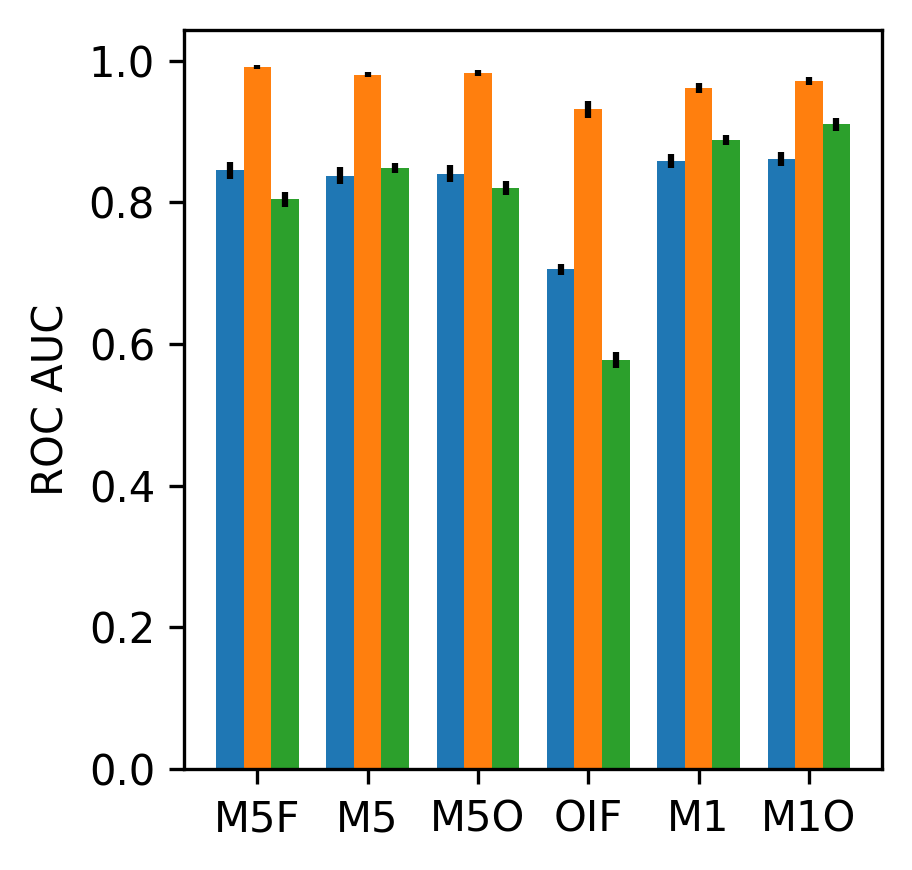

In [14]:
ind = np.arange(len(AUC_train_means_LR))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (3.14, 3), dpi = 300)
rects1 = ax.bar(ind - width, AUC_train_means_LR, width, yerr=AUC_train_std_LR,
                label='LR')
rects2 = ax.bar(ind, AUC_train_means_RF, width, yerr=AUC_train_std_RF,
                label='RF')
rects3 = ax.bar(ind + width, AUC_train_means_SVM, width, yerr=AUC_train_std_SVM,
                label='SVM')
ax.set_ylabel('ROC AUC')
#ax.set_title('Scores by Dataset and Model')
ax.set_xticks(ind)
ax.set_xticklabels(['M5F', 'M5', 'M5O', 'OIF', 'M1', 'M1O'])
#ax.legend()
fig.tight_layout()
plt.show()

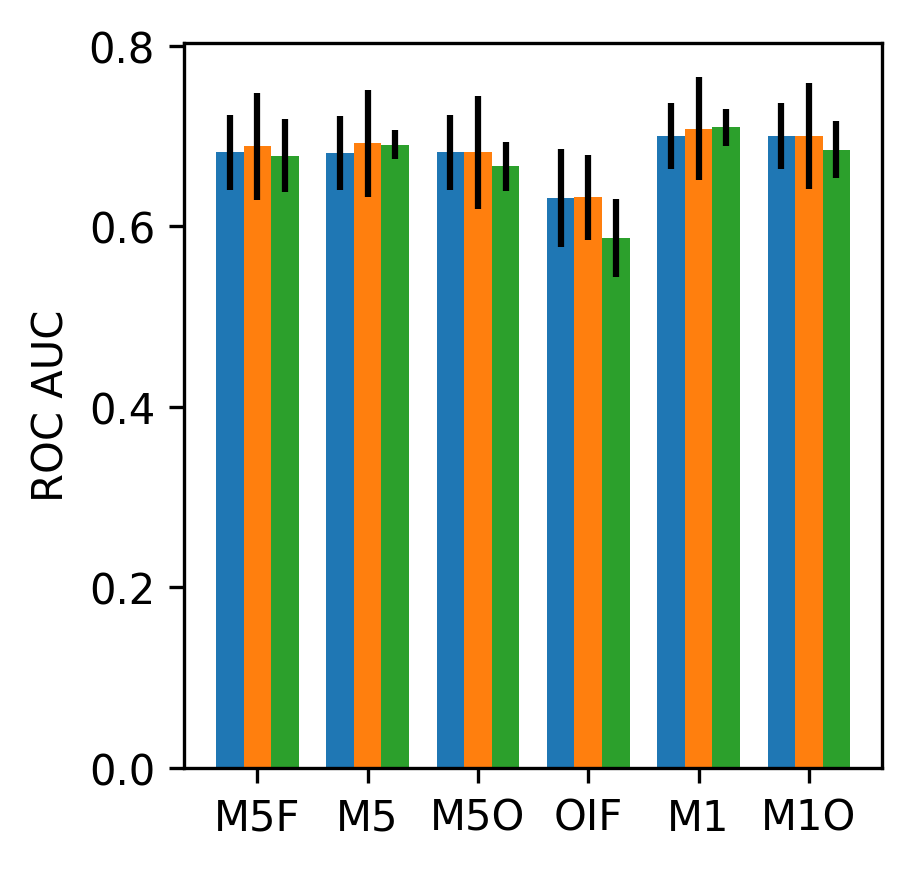

In [15]:
AUC_test_means_LR = best_models_metrics_df.ROCAUC_test[best_models_metrics_df.Model == 'LR']
AUC_test_std_LR = best_models_metrics_df.ROCAUC_test_std[best_models_metrics_df.Model == 'LR']
AUC_test_means_RF = best_models_metrics_df.ROCAUC_test[best_models_metrics_df.Model == 'RF']
AUC_test_std_RF = best_models_metrics_df.ROCAUC_test_std[best_models_metrics_df.Model == 'RF']
AUC_test_means_SVM = best_models_metrics_df.ROCAUC_test[best_models_metrics_df.Model == 'SVM']
AUC_test_std_SVM = best_models_metrics_df.ROCAUC_test_std[best_models_metrics_df.Model == 'SVM']
ind = np.arange(len(AUC_test_means_LR))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (3.14, 3), dpi = 300)
rects1 = ax.bar(ind - width, AUC_test_means_LR, width, yerr=AUC_test_std_LR,
                label='LR')
rects2 = ax.bar(ind, AUC_test_means_RF, width, yerr=AUC_test_std_RF,
                label='RF')
rects3 = ax.bar(ind + width, AUC_test_means_SVM, width, yerr=AUC_test_std_SVM,
                label='SVM')
ax.set_ylabel('ROC AUC')
#ax.set_title('Scores by Dataset and Model')
ax.set_xticks(ind)
ax.set_xticklabels(['M5F', 'M5', 'M5O', 'OIF', 'M1', 'M1O'])
#ax.legend()
fig.tight_layout()
plt.show()

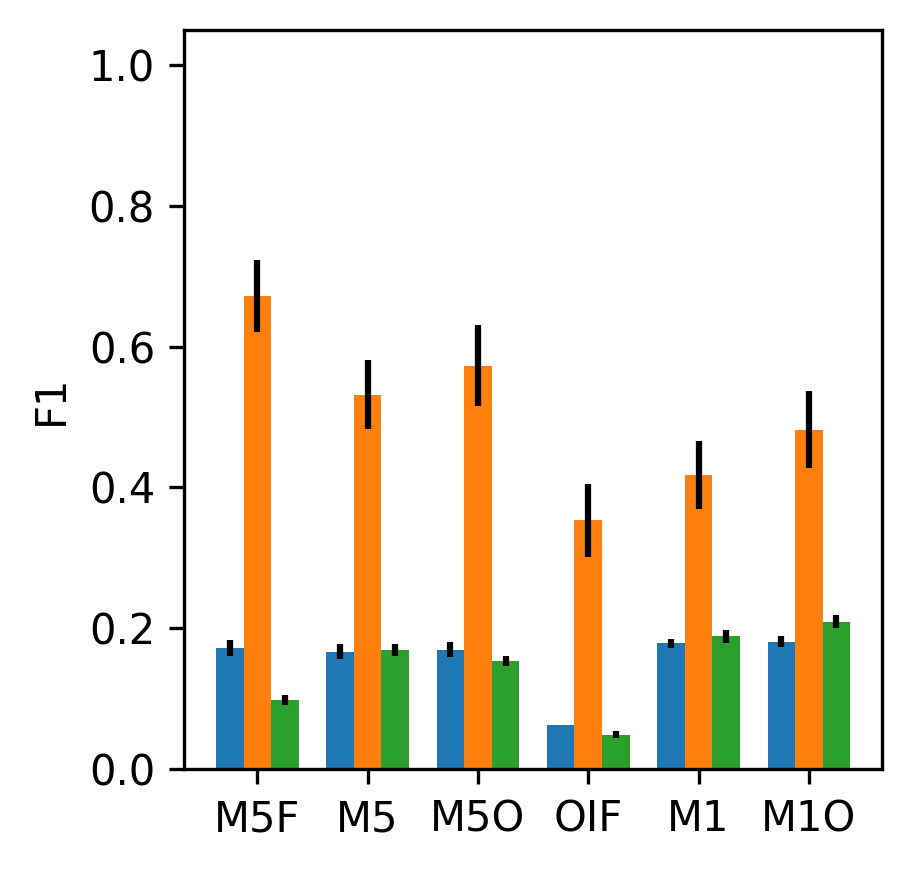

In [16]:
F1_train_means_LR = best_models_metrics_df.F1_train[best_models_metrics_df.Model == 'LR']
F1_train_std_LR = best_models_metrics_df.F1_train_std[best_models_metrics_df.Model == 'LR']
F1_train_means_RF = best_models_metrics_df.F1_train[best_models_metrics_df.Model == 'RF']
F1_train_std_RF = best_models_metrics_df.F1_train_std[best_models_metrics_df.Model == 'RF']
F1_train_means_SVM = best_models_metrics_df.F1_train[best_models_metrics_df.Model == 'SVM']
F1_train_std_SVM = best_models_metrics_df.F1_train_std[best_models_metrics_df.Model == 'SVM']
ind = np.arange(len(F1_train_means_LR))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (3.14, 3), dpi = 300)
plt.ylim(0,1.05)
rects1 = ax.bar(ind - width, F1_train_means_LR, width, yerr=F1_train_std_LR,
                label='LR')
rects2 = ax.bar(ind, F1_train_means_RF, width, yerr=F1_train_std_RF,
                label='RF')
rects3 = ax.bar(ind + width, F1_train_means_SVM, width, yerr=F1_train_std_SVM,
                label='SVM')
ax.set_ylabel('F1')
#ax.set_title('Scores by Dataset and Model')
ax.set_xticks(ind)
ax.set_xticklabels(['M5F', 'M5', 'M5O', 'OIF', 'M1', 'M1O'])
#ax.legend()
fig.tight_layout()

plt.show()

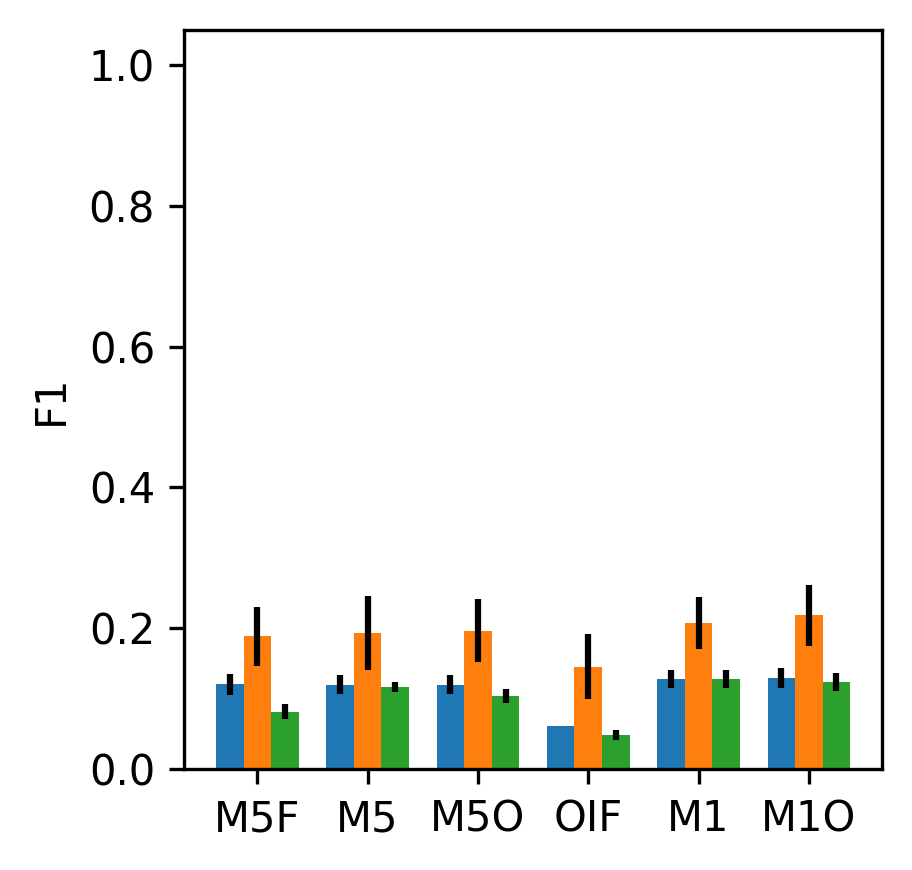

In [17]:
F1_test_means_LR = best_models_metrics_df.F1_test[best_models_metrics_df.Model == 'LR']
F1_test_std_LR = best_models_metrics_df.F1_test_std[best_models_metrics_df.Model == 'LR']
F1_test_means_RF = best_models_metrics_df.F1_test[best_models_metrics_df.Model == 'RF']
F1_test_std_RF = best_models_metrics_df.F1_test_std[best_models_metrics_df.Model == 'RF']
F1_test_means_SVM = best_models_metrics_df.F1_test[best_models_metrics_df.Model == 'SVM']
F1_test_std_SVM = best_models_metrics_df.F1_test_std[best_models_metrics_df.Model == 'SVM']
ind = np.arange(len(F1_train_means_LR))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (3.14, 3), dpi = 300)
plt.ylim(0,1.05)
rects1 = ax.bar(ind - width, F1_test_means_LR, width, yerr=F1_test_std_LR,
                label='LR')
rects2 = ax.bar(ind, F1_test_means_RF, width, yerr=F1_test_std_RF,
                label='RF')
rects3 = ax.bar(ind + width, F1_test_means_SVM, width, yerr=F1_test_std_SVM,
                label='SVM')
ax.set_ylabel('F1')
#ax.set_title('Scores by Dataset and Model')
ax.set_xticks(ind)
ax.set_xticklabels(['M5F', 'M5', 'M5O', 'OIF', 'M1', 'M1O'])
#ax.legend()
fig.tight_layout()

plt.show()

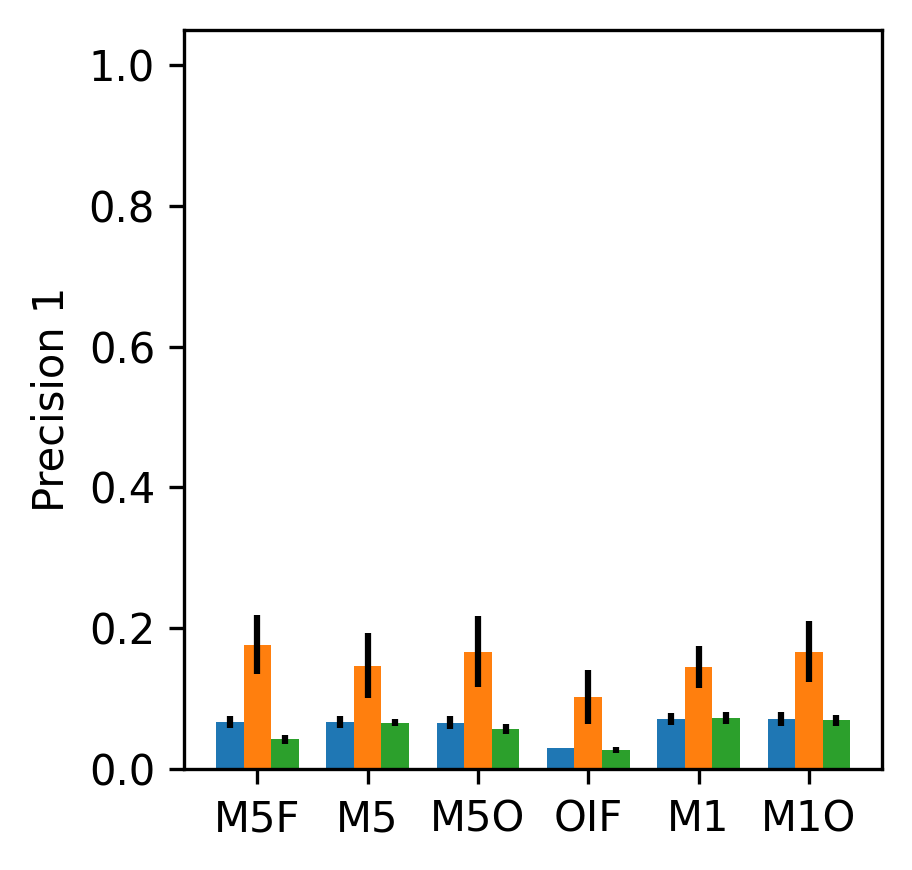

In [19]:
pre_test_means_LR = best_models_metrics_df.Precision1_test[best_models_metrics_df.Model == 'LR']
pre_test_std_LR = best_models_metrics_df.Precision1_test_std[best_models_metrics_df.Model == 'LR']
pre_test_means_RF = best_models_metrics_df.Precision1_test[best_models_metrics_df.Model == 'RF']
pre_test_std_RF = best_models_metrics_df.Precision1_test_std[best_models_metrics_df.Model == 'RF']
pre_test_means_SVM = best_models_metrics_df.Precision1_test[best_models_metrics_df.Model == 'SVM']
pre_test_std_SVM = best_models_metrics_df.Precision1_test_std[best_models_metrics_df.Model == 'SVM']
ind = np.arange(len(F1_train_means_LR))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (3.14, 3), dpi = 300)
plt.ylim(0,1.05)
rects1 = ax.bar(ind - width, pre_test_means_LR, width, yerr=pre_test_std_LR,
                label='LR')
rects2 = ax.bar(ind, pre_test_means_RF, width, yerr=pre_test_std_RF,
                label='RF')
rects3 = ax.bar(ind + width, pre_test_means_SVM, width, yerr=pre_test_std_SVM,
                label='SVM')
ax.set_ylabel('Precision 1')
#ax.set_title('Scores by Dataset and Model')
ax.set_xticks(ind)
ax.set_xticklabels(['M5F', 'M5', 'M5O', 'OIF', 'M1', 'M1O'])
#ax.legend()
fig.tight_layout()

plt.show()

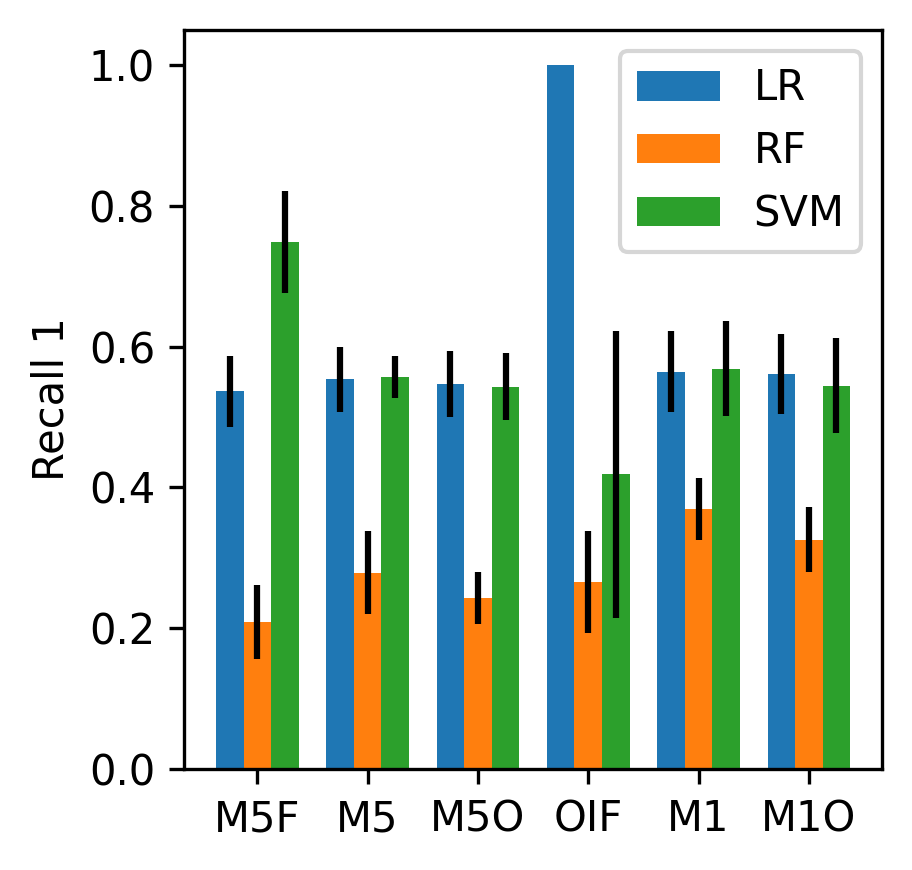

In [20]:
rec_test_means_LR = best_models_metrics_df.Recall1_test[best_models_metrics_df.Model == 'LR']
rec_test_std_LR = best_models_metrics_df.Recall1_test_std[best_models_metrics_df.Model == 'LR']
rec_test_means_RF = best_models_metrics_df.Recall1_test[best_models_metrics_df.Model == 'RF']
rec_test_std_RF = best_models_metrics_df.Recall1_test_std[best_models_metrics_df.Model == 'RF']
rec_test_means_SVM = best_models_metrics_df.Recall1_test[best_models_metrics_df.Model == 'SVM']
rec_test_std_SVM = best_models_metrics_df.Recall1_test_std[best_models_metrics_df.Model == 'SVM']
ind = np.arange(len(F1_train_means_LR))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (3.14, 3), dpi = 300)
rects1 = ax.bar(ind - width, rec_test_means_LR, width, yerr=rec_test_std_LR,
                label='LR')
rects2 = ax.bar(ind, rec_test_means_RF, width, yerr=rec_test_std_RF,
                label='RF')
rects3 = ax.bar(ind + width, rec_test_means_SVM, width, yerr=rec_test_std_SVM,
                label='SVM')
ax.set_ylabel('Recall 1')
#ax.set_title('Scores by Dataset and Model')
ax.set_xticks(ind)
ax.set_xticklabels(['M5F', 'M5', 'M5O', 'OIF', 'M1', 'M1O'])
ax.legend()
fig.tight_layout()

plt.show()

### Best models - precision@k, recall@k

In [ ]:
def precision_at_k(y_true, y_score, k, pos_label=1):
    from sklearn.utils import column_or_1d
    from sklearn.utils.multiclass import type_of_target
    
    y_true_type = type_of_target(y_true)
    if not (y_true_type == "binary"):
        raise ValueError("y_true must be a binary column.")
    
    # Makes this compatible with various array types
    y_true_arr = column_or_1d(y_true)
    y_score_arr = column_or_1d(y_score)
    
    y_true_arr = y_true_arr == pos_label
    
    desc_sort_order = np.argsort(y_score_arr)[::-1]
    y_true_sorted = y_true_arr[desc_sort_order]
    y_score_sorted = y_score_arr[desc_sort_order]
    
    true_positives = y_true_sorted[:k].sum()
    
    return true_positives / k

In [ ]:
def recall_at_k(y_true, y_score, k, pos_label=1):
    from sklearn.utils import column_or_1d
    from sklearn.utils.multiclass import type_of_target
    
    y_true_type = type_of_target(y_true)
    if not (y_true_type == "binary"):
        raise ValueError("y_true must be a binary column.")
    
    # Makes this compatible with various array types
    y_true_arr = column_or_1d(y_true)
    y_score_arr = column_or_1d(y_score)
    
    y_true_arr = y_true_arr == pos_label
    
    desc_sort_order = np.argsort(y_score_arr)[::-1]
    y_true_sorted = y_true_arr[desc_sort_order]
    y_score_sorted = y_score_arr[desc_sort_order]
    
    true_positives = y_true_sorted[:k].sum()
    
    return true_positives / y_true.sum()

In [ ]:
best_models_atk= {'Set4':[], 'Set5':[], 'Set6': [], 'Set7':[], 'Set8':[], 'Set9':[]} #If other datasets a explored - 
                                                                                     # change this dictionary
for m in best_models:
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_test_clean = X_test.drop('Chembl_Name', axis=1)
    scaler = MinMaxScaler()
    scaler.fit(X_train_clean)
    X_train_clean = scaler.transform(X_train_clean)
    X_test_clean = scaler.transform(X_test_clean)
    models_list = []
    for j in range(len(best_models[m])):
        model = best_models[m][j]
        model.fit(X_train_clean, y_train)
        models_list.append(model)
        y_pred_proba = model.predict_proba(X_test_clean)[:,1]
        Test_df_preds = pd.concat([ 
                          pd.DataFrame(y_pred_proba, columns=['pred_proba']),
                          pd.DataFrame([int(i>=0.5) for i in y_pred_proba], columns=['max_pred']),
                          y_test.reset_index(drop=True)], axis = 1)
        Test_df_preds = Test_df_preds.sort_values(by='pred_proba', ascending=False)

        p_at_k = []
        r_at_k = []
        for i in range(10,101,5):
            pak = precision_at_k(Test_df_preds['Experiment_label'],Test_df_preds['max_pred'],i)
            rak = recall_at_k(Test_df_preds['Experiment_label'],Test_df_preds['max_pred'],i)
            p_at_k.append(pak)
            r_at_k.append(rak)
        best_models_atk[m].append([p_at_k,r_at_k])
    best_models[m] = models_list


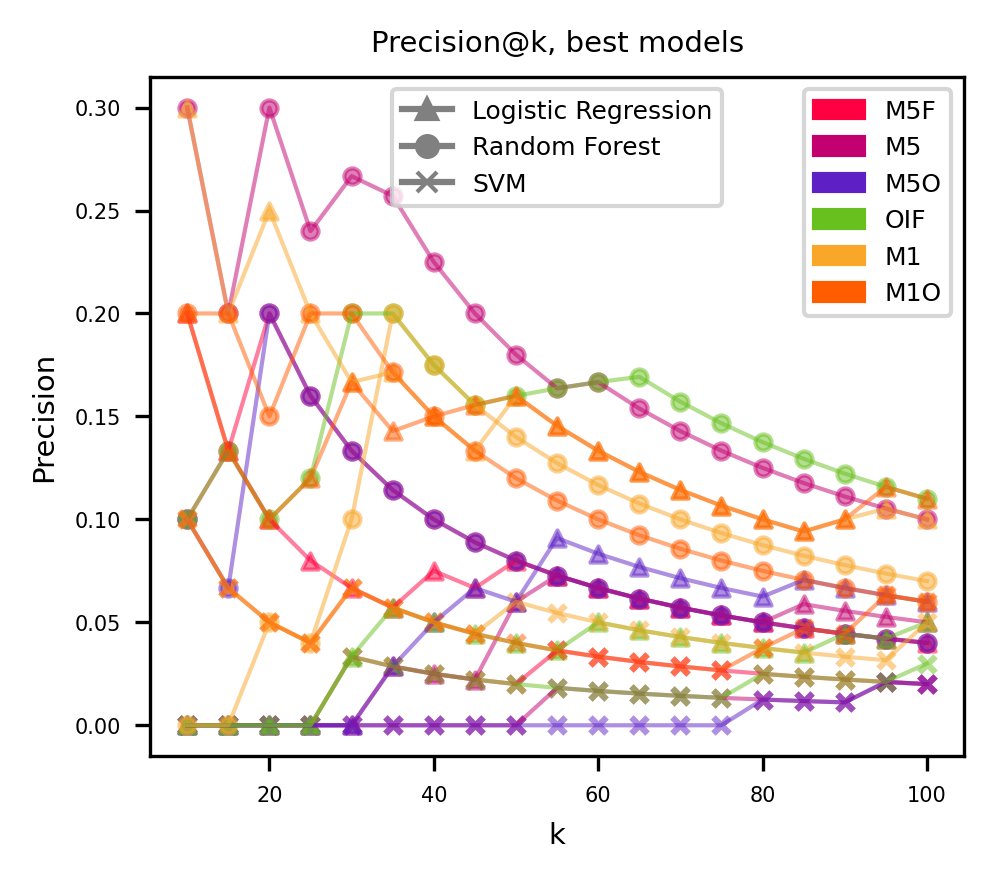

In [ ]:
import matplotlib.lines as mlines
fig, ax = plt.subplots(figsize = (3.5, 3), dpi = 300)
plt.rc('xtick', labelsize=5) 
plt.rc('ytick', labelsize=5) 
plt.xlabel('k', size=7)
plt.ylabel('Precision', size=7)
plt.title('Precision@k, best models', size=7)
plot_y = list(range(10,101,5))
model_names = ['Logistic Regression', 'Random Forest', "SVM"]
Set_names = ['Set4', 'Set5','Set6','Set7', 'Set8', 'Set9']
marker_list = ['^', 'o', 'x']
color_list = ['#FF0040', '#C30070', '#5E20C5',    '#68C01E', '#F9A729','#FF5D00'] 
               #'#FF7400','#4D64AF', '#206CC5'] #,"#175A04",

for i in range(6):
    name = Set_names[i]
    for j in range(3):
        x = best_models_atk[name][j][0]
        plt.scatter(plot_y,x,s=15, c=color_list[i], alpha=0.5, marker=marker_list[j],
            label='{}, {}'.format(names[Set_names[i]], model_names[j]))
        plt.plot(plot_y,x, c=color_list[i], alpha=0.5, linewidth=1,
            label='{}, {}'.format(names[Set_names[i]], model_names[j]))
patches = [mpatches.Patch(color=color_list[i], label=names[Set_names[i]]) for i in range(6)]
first_legend = ax.legend(handles=patches, loc=1,prop={'size': 6})
ax.add_artist(first_legend)
lines = [mlines.Line2D([], [], color='gray', marker=marker_list[i],
                          markersize=5, label=model_names[i]) for i in range(3)]
ax.legend(handles=lines, loc=9,prop={'size': 6}) 
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Chembl4495582/Precision_at_k_Chembl4495582_best_models.png', bbox_inches='tight')

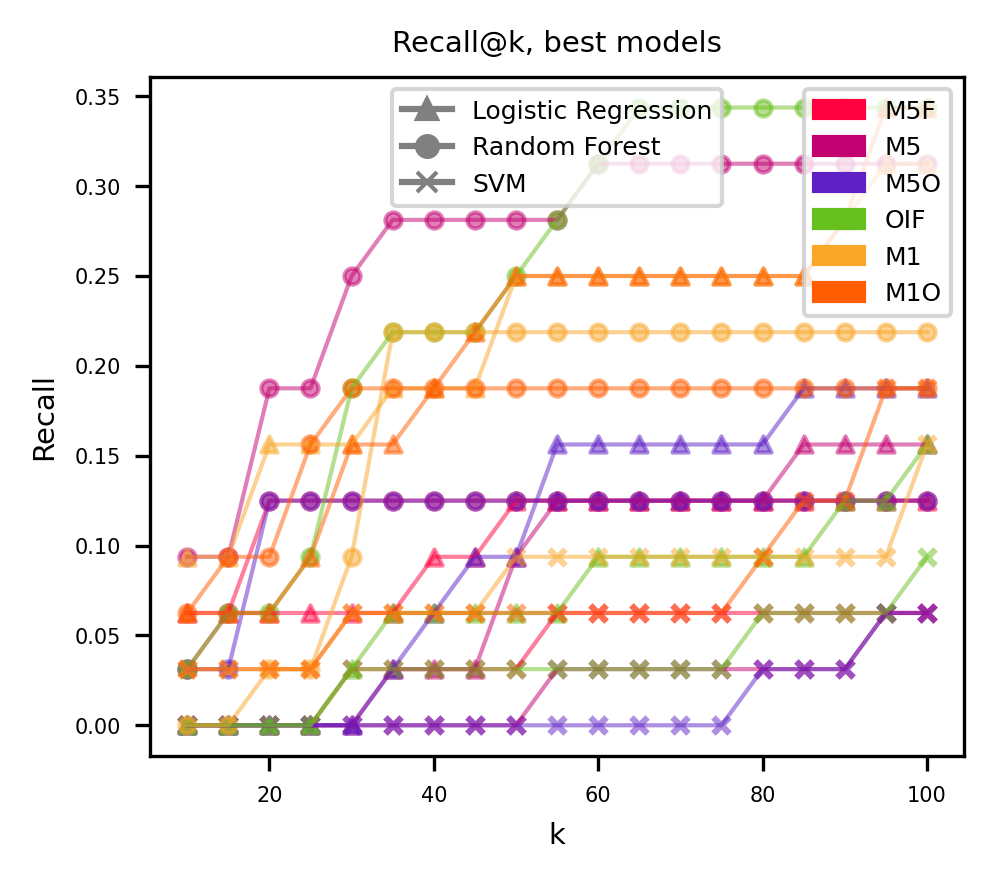

In [ ]:
import matplotlib.lines as mlines
import random
fig, ax = plt.subplots(figsize = (3.5, 3), dpi = 300)
plt.rc('xtick', labelsize=5) 
plt.rc('ytick', labelsize=5) 
plt.xlabel('k', size=7)
plt.ylabel('Recall', size=7)
plt.title('Recall@k, best models', size=7)
plot_y = list(range(10,101,5))
model_names = ['Logistic Regression', 'Random Forest', "SVM"]
Set_names = ['Set4', 'Set5','Set6','Set7', 'Set8', 'Set9']
marker_list = ['^', 'o', 'x']
color_list = ['#FF0040', '#C30070', '#5E20C5',    '#68C01E', '#F9A729','#FF5D00'] 
               #'#FF7400','#4D64AF', '#206CC5'] #,"#175A04",

for i in range(6):
    name = Set_names[i]
    for j in range(3):
        
        x = best_models_atk[name][j][1]
        plt.scatter(plot_y,x,s=15, c=color_list[i], alpha=0.5, marker=marker_list[j],
            label='{}, {}'.format(names[Set_names[i]], model_names[j]))
        plt.plot(plot_y,x, c=color_list[i], alpha=0.5, linewidth=1,
            label='{}, {}'.format(names[Set_names[i]], model_names[j]))
patches = [mpatches.Patch(color=color_list[i], label=names[Set_names[i]]) for i in range(6)]
first_legend = ax.legend(handles=patches, loc=1,prop={'size': 6})
ax.add_artist(first_legend)
lines = [mlines.Line2D([], [], color='gray', marker=marker_list[i],
                          markersize=5, label=model_names[i]) for i in range(3)]
ax.legend(handles=lines, loc=9,prop={'size': 6}) 
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Chembl4495582/Recall_at_k_Chembl4495582_best_models.png', bbox_inches='tight')

# ROC Curves

In [ ]:
from sklearn.utils import shuffle

In [ ]:
Chembl_gridscores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_with_gridscores.scv', index_col=0)

In [ ]:
names = {"Set1": 'OHF', 'Set2':'FL','Set3':'FLE','Set4':'M5F','Set5':'M5','Set6':'M5O','Set7':'OIF','Set8':'M1', 'Set9':'M1O'} 

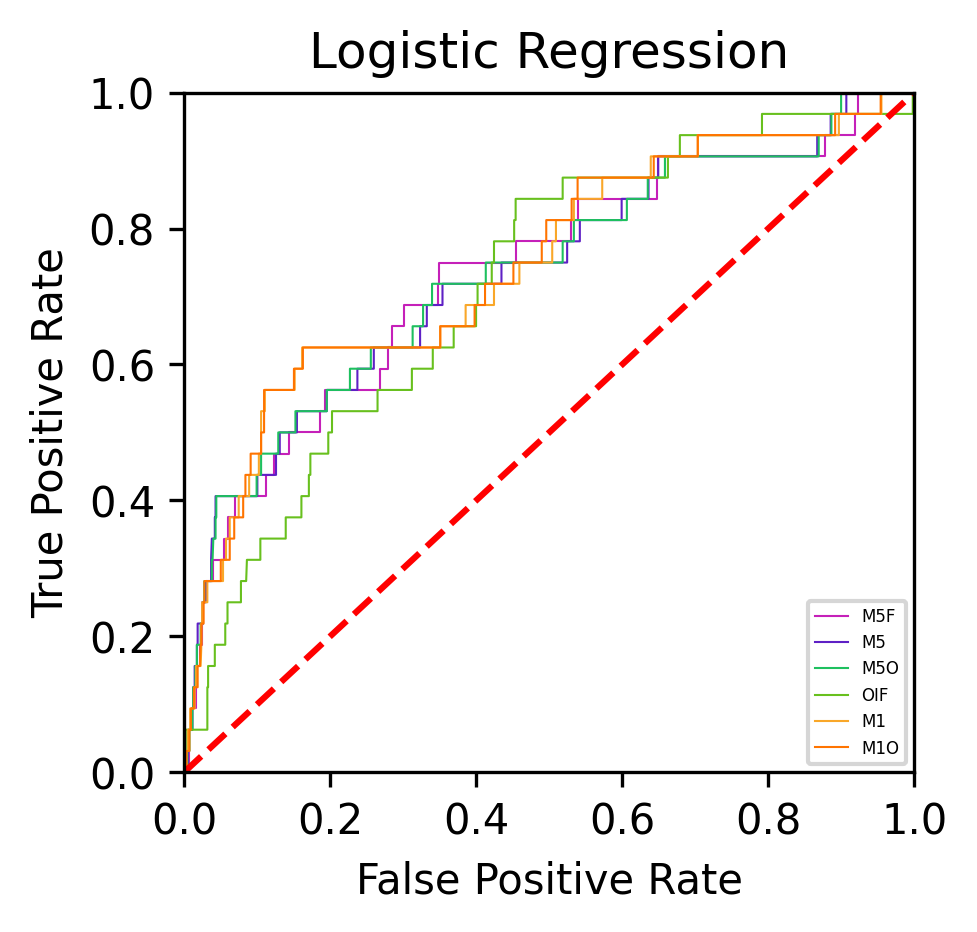

In [ ]:
plt.figure(figsize = (3.14, 3), dpi = 300)
import matplotlib.colors as colors
colors_list = ['#FF3B68', '#C520B9', '#5E20C5',   '#1EC05F', '#68C01E', '#F9A729', 
               '#FF7400','#4D64AF'] #'#206CC5',"#175A04",
plt.title('Logistic Regression')
j = 0
good_model = []
rocauc_summery = []
ld = Chembl_gridscores
y = ld['Experiment_label']
X = ld.drop('Experiment_label', axis=1)
ld_train, ld_val, ld_test, yld_train, yld_val, yld_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
fpr, tpr, threshold = metrics.roc_curve(yld_val, ld_val["positive_Minscore"])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Docking minscore, auc = {}'.format(round(roc_auc, 2)), color = colors_list[j], 
            linewidth=0.5)
j +=1
rocauc_summery += [['Docking minscore', roc_auc]]
#random model
y = ld['Experiment_label']
fpr1, tpr1, threshold = metrics.roc_curve(y,shuffle(y, random_state = 42))
roc_auc = metrics.auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, 'r--', label = 'Random, auc = {}'.format(round(roc_auc, 2)), color = '#FF0000', 
            linewidth=1.5)

for m in best_models:
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    scaler = MinMaxScaler()
    scaler.fit(X_train_clean)
    X_train_clean = scaler.transform(X_train_clean)
    X_val_clean = scaler.transform(X_val_clean)
    
    model = best_models[m][0]
    #model.fit(X_train_clean, y_train)
    fpr, tpr, threshold = metr.roc_curve(y_val,model.predict_proba(X_val_clean).transpose()[1])
    roc_auc = metr.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = names[m], color = colors_list[j], 
            linewidth=0.5)
    j +=1
    rocauc_summery += [[m, roc_auc]]
    if roc_auc >=0.65:
        good_model += [[m, roc_auc]]
plt.legend(loc = 'lower right', prop={'size': 4})
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#lt.savefig('ROCAUC_ensemble1.png', bbox_inches='tight')
plt.show()

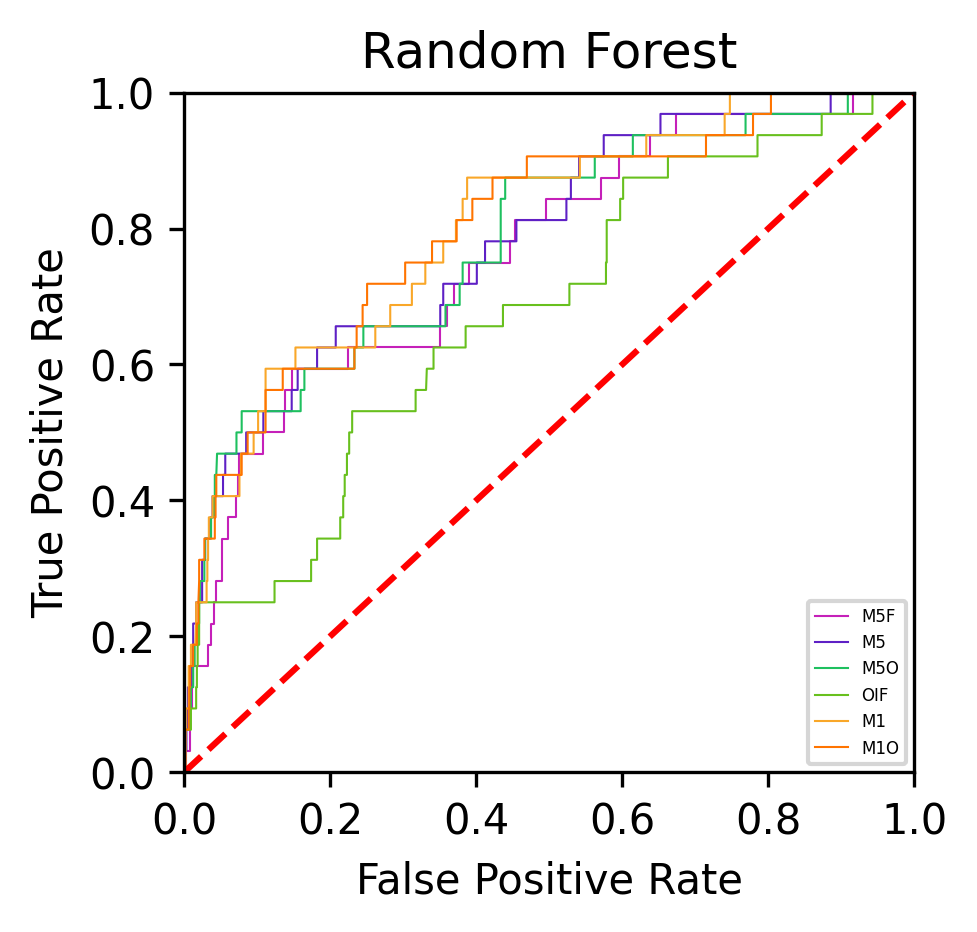

In [ ]:
plt.figure(figsize = (3.14, 3), dpi = 300)
import matplotlib.colors as colors
colors_list = ['#FF3B68', '#C520B9', '#5E20C5',   '#1EC05F', '#68C01E', '#F9A729', 
               '#FF7400','#4D64AF'] #'#206CC5',"#175A04",
plt.title('Random Forest')
j = 0
good_model = []
rocauc_summery = []
j +=1
#rocauc_summery += [['Docking minscore', roc_auc]]
#random model
#y = ld['Experiment_label']
#fpr1, tpr1, threshold = metrics.roc_curve(y,shuffle(y, random_state = 42))
#roc_auc = metrics.auc(fpr1, tpr1)
#plt.plot(fpr1, tpr1, 'r--', label = 'Random, auc = {}'.format(round(roc_auc, 2)), color = '#FF0000', 
#            linewidth=1.5)
#if roc_auc >=0.65:
#    good_model += [['Docking minscore', roc_auc]]
for m in best_models:
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    scaler = MinMaxScaler()
    scaler.fit(X_train_clean)
    X_train_clean = scaler.transform(X_train_clean)
    X_val_clean = scaler.transform(X_val_clean)
    
    model = best_models[m][1]
    #model.fit(X_train_clean, y_train)
    fpr, tpr, threshold = metr.roc_curve(y_val,model.predict_proba(X_val_clean).transpose()[1])
    roc_auc = metr.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = names[m], color = colors_list[j], 
            linewidth=0.5)
    j +=1
    rocauc_summery += [[m, roc_auc]]
    if roc_auc >=0.65:
        good_model += [[m, roc_auc]]
plt.legend(loc = 'lower right', prop={'size': 4})
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#lt.savefig('ROCAUC_ensemble1.png', bbox_inches='tight')
plt.show()

FileNotFoundError: ignored

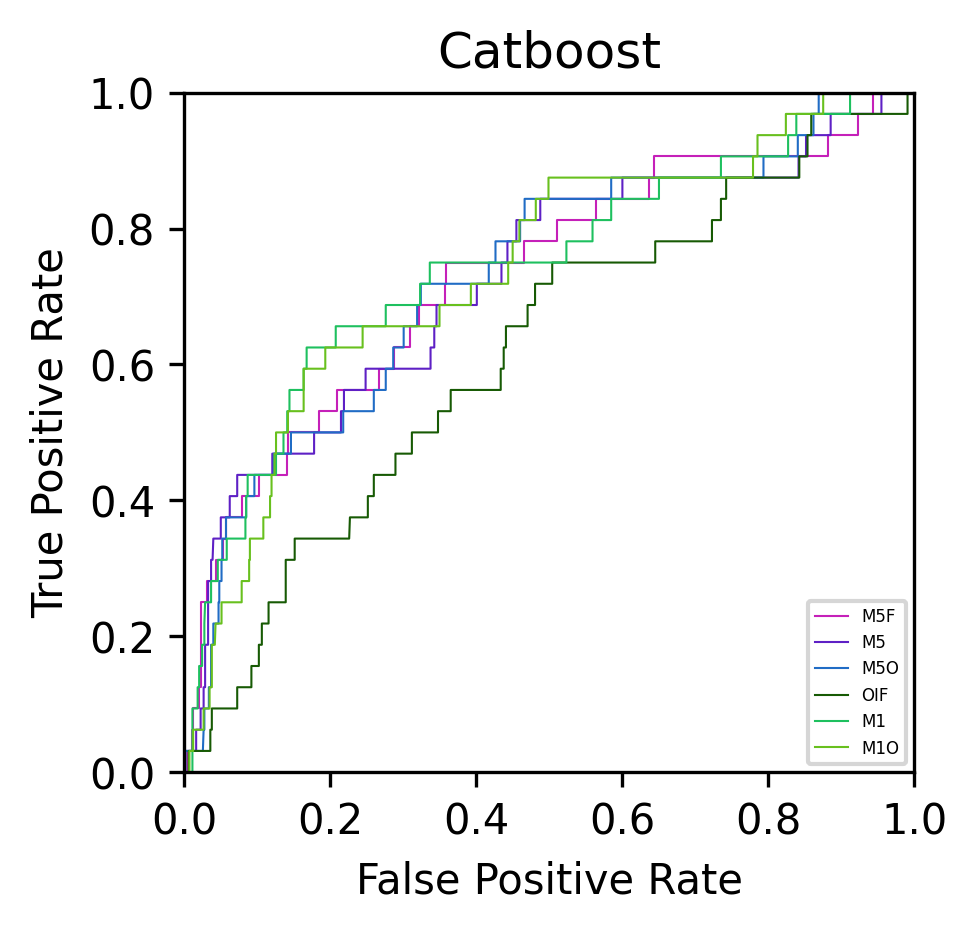

In [ ]:
plt.figure(figsize = (3.14, 3), dpi = 300)
import matplotlib.colors as colors
colors_list = ['#FF3B68', '#C520B9', '#5E20C5', '#206CC5', "#175A04", '#1EC05F', '#68C01E', '#F9A729', 
               '#FF7400','#4D64AF']
plt.title('Catboost')
j = 0
good_model = []
rocauc_summery = []

j +=1

#random model

for m in best_models:
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    scaler = MinMaxScaler()
    scaler.fit(X_train_clean)
    X_train_clean = scaler.transform(X_train_clean)
    X_val_clean = scaler.transform(X_val_clean)
    
    model = best_models[m][2]
    #model.fit(X_train_clean, y_train)
    fpr, tpr, threshold = metr.roc_curve(y_val,model.predict_proba(X_val_clean).transpose()[1])
    roc_auc = metr.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = names[m], color = colors_list[j], 
            linewidth=0.5)
    j +=1
    rocauc_summery += [[m, roc_auc]]
    if roc_auc >=0.65:
        good_model += [[m, roc_auc]]
plt.legend(loc = 'lower right', prop={'size': 4})
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#lt.savefig('ROCAUC_ensemble1.png', bbox_inches='tight')
plt.show()

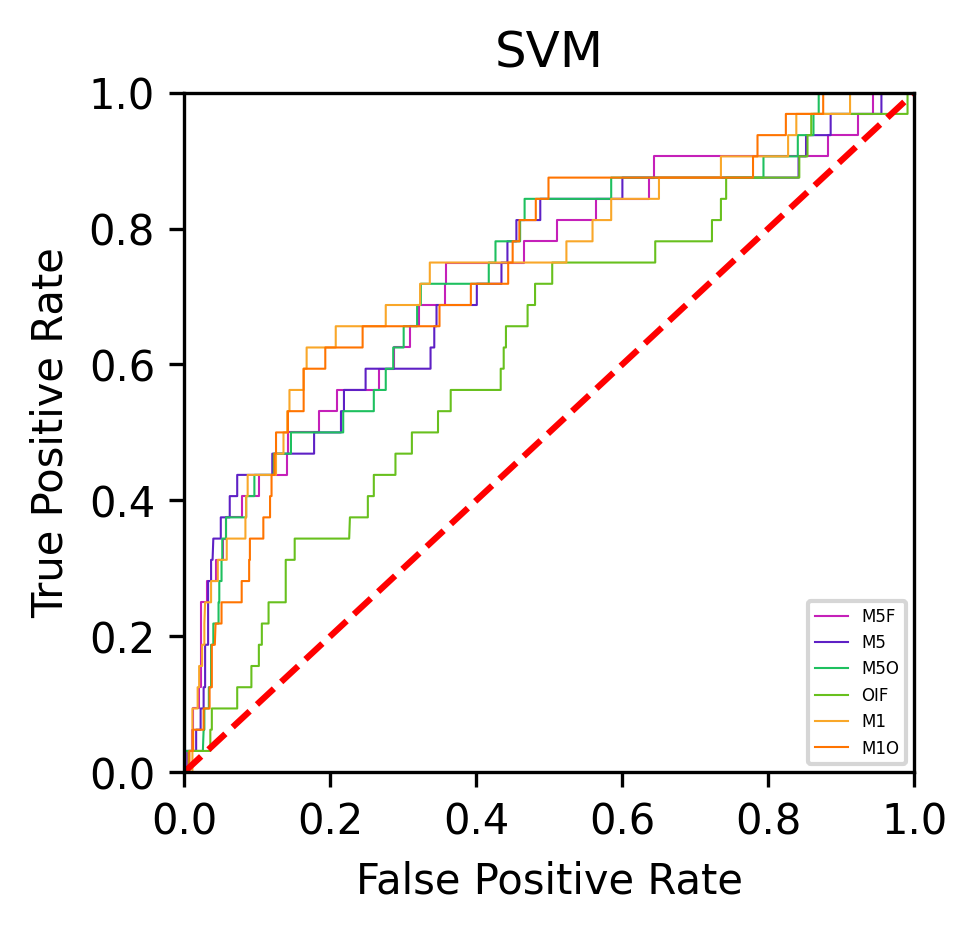

In [ ]:
plt.figure(figsize = (3.14, 3), dpi = 300)
import matplotlib.colors as colors
colors_list = ['#FF3B68', '#C520B9', '#5E20C5',   '#1EC05F', '#68C01E', '#F9A729', 
               '#FF7400','#4D64AF'] #'#206CC5',"#175A04",
plt.title('SVM')
j = 0
good_model = []
rocauc_summery = []

j +=1

for m in best_models:
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    scaler = MinMaxScaler()
    scaler.fit(X_train_clean)
    X_train_clean = scaler.transform(X_train_clean)
    X_val_clean = scaler.transform(X_val_clean)
    
    model = best_models[m][2]
    #model.fit(X_train_clean, y_train)
    fpr, tpr, threshold = metr.roc_curve(y_val,model.predict_proba(X_val_clean).transpose()[1])
    roc_auc = metr.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = names[m], color = colors_list[j], 
            linewidth=0.5)
    j +=1
    rocauc_summery += [[m, roc_auc]]
    if roc_auc >=0.65:
        good_model += [[m, roc_auc]]
plt.legend(loc = 'lower right', prop={'size': 4})
plt.plot([0, 1], [0, 1],'r--',label = 'Random, auc = 0.5')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#lt.savefig('ROCAUC_ensemble1.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize = (3.14, 3), dpi = 300)
import matplotlib.colors as colors
colors_list = ['#FF3B68', '#C520B9', '#5E20C5', '#206CC5', "#175A04", '#1EC05F', '#68C01E', '#F9A729', 
               '#FF7400','#4D64AF']
plt.title('ROC-curve Tabnet')
j = 0
good_model = []
rocauc_summery = []
ld = Chembl_gridscores.merge(chembl_data, on = 'Chembl_Name')
y = ld['Experiment_label_y']
X = ld.drop('Experiment_label_y', axis=1)
ld_train, ld_val, ld_test, yld_train, yld_val, yld_test = train_test_val_prep(X, y, test_size = 0.3, 
                                                                              random_state = 42)
fpr, tpr, threshold = metrics.roc_curve(yld_val, ld_val["positive_Minscore"])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Docking minscore, auc = {}'.format(round(roc_auc, 2)), color = colors_list[j], 
            linewidth=0.5)
j +=1
rocauc_summery += [['Docking minscore', roc_auc]]
#random model

fpr1, tpr1, threshold = metrics.roc_curve(y,shuffle(y, random_state = 42))
roc_auc = metrics.auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, 'r--', label = 'Random, auc = {}'.format(round(roc_auc, 2)), color = '#FF0000', 
            linewidth=1.5)
if roc_auc >=0.65:
    good_model += [['Docking minscore', roc_auc]]
for m in best_models:
    dataset = Datasets_Dict[m]
    y = dataset['Experiment_label']
    X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    X_train_clean = X_train.drop('Chembl_Name', axis=1)
    X_val_clean = X_val.drop('Chembl_Name', axis=1)
    scaler = MinMaxScaler()
    scaler.fit(X_train_clean)
    X_train_clean = scaler.transform(X_train_clean)
    X_val_clean = scaler.transform(X_val_clean)
    
    model = best_models[m][4]
    #model.fit(X_train_clean, y_train)
    fpr, tpr, threshold = metrics.roc_curve(y_val,model.predict_proba(X_val_clean).transpose()[1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = '{}, auc = {}'.format(m, round(roc_auc, 2)), color = colors_list[j], 
            linewidth=0.5)
    j +=1
    rocauc_summery += [[m, roc_auc]]
    if roc_auc >=0.65:
        good_model += [[m, roc_auc]]

#plt.plot([0, 1], [0, 1],'r--',label = 'Random, auc = 0.5')
plt.legend(loc = 'lower right', prop={'size': 4})
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#lt.savefig('ROCAUC_ensemble1.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize = (3.14, 3), dpi = 300)
import matplotlib.colors as colors
colors_list = ['#FF3B68', '#C520B9', '#5E20C5', '#206CC5', "#175A04", '#1EC05F', '#68C01E', '#F9A729', 
               '#FF7400','#4D64AF']
plt.title('ROC-curve Set5')
j = 0


m = 'Set5'
dataset = Datasets_Dict[m]
y = dataset['Experiment_label']
X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
X_train_clean = X_train.drop('Chembl_Name', axis=1)
X_val_clean = X_val.drop('Chembl_Name', axis=1)
scaler = MinMaxScaler()
scaler.fit(X_train_clean)
X_train_clean = scaler.transform(X_train_clean)
X_val_clean = scaler.transform(X_val_clean)
ld = Chembl_gridscores.merge(chembl_data, on = 'Chembl_Name')
ld = X_val.merge(ld, on = 'Chembl_Name')
good_model = []
rocauc_summery = []
#docking minscore
ld = ld.sort_values(by = "positive_Minscore")
fpr, tpr, threshold = metrics.roc_curve(ld.Experiment_label_y, ld["positive_Minscore"])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Docking minscore, auc = {}'.format(round(roc_auc, 2)), color = colors_list[j], 
            linewidth=0.5)

j +=1
rocauc_summery += [['Docking minscore', roc_auc]]
#random_model
fpr1, tpr1, threshold = metrics.roc_curve(y_val,shuffle(y_val, random_state = 42))
roc_auc = metrics.auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, 'r--', label = 'Random, auc = {}'.format(round(roc_auc, 2)), color = '#FF0000', 
            linewidth=1.5)
for i in range(len(best_models[m])):
    model = best_models[m][i]
    #model.fit(X_train_clean, y_train)
    fpr, tpr, threshold = metrics.roc_curve(y_val,model.predict_proba(X_val_clean).transpose()[1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = '{}, auc = {}'.format(models_names_list[i], round(roc_auc, 2)), color = colors_list[j], 
            linewidth=0.5)
    j +=1
    rocauc_summery += [[m, roc_auc]]
    if roc_auc >=0.65:
        good_model += [[m, roc_auc]]
plt.legend(loc = 'lower right', prop={'size': 4})
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#lt.savefig('ROCAUC_ensemble1.png', bbox_inches='tight')
plt.show()

# Catboost - let's try more parameters

In [ ]:
def gridsearchCV_catboost(X_t, X_v, y_t, y_v, estimator, scoring, estimator_hyprms, n_splits):
    skf = StratifiedKFold(n_splits=n_splits)
    cv = skf.split(X_t, y_t)
    # Grid search
    estimator_pipeline = Pipeline([('scaler', MinMaxScaler()), ('estimator', estimator)])
    gs = GridSearchCV(
            estimator    = estimator_pipeline,
            param_grid   = estimator_hyprms,
            cv           = cv,
            scoring      = scoring,
            n_jobs       = 4
    )
    
    # Fit and evaluate the estimator
    gs.fit(X_t, y_t)
    #GSCV_report(gs, X_t, X_v, y_t, y_v)
    return gs

In [ ]:
#Set7
dataset = Datasets_Dict['Set{}'.format(7)]
y = dataset['Experiment_label']
X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    
scoring          = 'recall'
estimator_name   = 'Cat Boost'
estimator        = CatBoostClassifier(learning_rate=0.5,verbose=False) 
estimator_hyprms = {
        'estimator__depth'          : [3,4,5],
        'estimator__n_estimators'   : [200,500,1000],
        'estimator__l2_leaf_reg': [1,5,10,40],
        'estimator__od_pval'    : [10^-10, 0],
        'estimator__rsm'        : [0.8, 1],
        'estimator__random_strength'  :[1, 3]
        
        }
skf = StratifiedKFold(n_splits=5)
cv = skf.split(X_train, y_train)
n_splits = 5
    
X_train_clean = X_train.drop('Chembl_Name', axis=1)
X_val_clean = X_val.drop('Chembl_Name', axis=1)
model = gridsearchCV_catboost(X_train_clean, 
                                   X_val_clean, 
                                   y_train, y_val, estimator, scoring, estimator_hyprms, n_splits)

In [ ]:
GSCV_report(model, X_train_clean, X_val_clean, y_train, y_val)
GSCV_report_class(model, X_train_clean, X_val_clean, y_train, y_val)

********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.040
----------- 	 Train--Val
- ROC-AUC:  	1.000, 0.530
- F1:       	1.000, 0.150
- Precision:	1.000, 0.375
- Recall:   	1.000, 0.094
- Best hyperparameters {'estimator__depth': 3, 'estimator__l2_leaf_reg': 1, 'estimator__n_estimators': 500, 'estimator__od_pval': 0, 'estimator__random_strength': 3, 'estimator__rsm': 0.8}
******************************************

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4562
           1       1.00      1.00      1.00       150

    accuracy                           1.00      4712
   macro avg       1.00      1.00      1.00      4712
weighted avg       1.00      1.00      1.00      4712

Validation report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       978
           1       0.38      0.09      0.15        32

    accuracy                           0.97      1010


In [ ]:
dataset = Datasets_Dict['Set{}'.format(8)]
y = dataset['Experiment_label']
X = dataset.drop(['Experiment_label', 'Experiment_rank','Percent'], axis = 1)
X_train_set8, X_val_set8, X_test_set8, y_train_set8, y_val_set8, y_test_set8 = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
    
scoring          = 'recall'
estimator_name   = 'Cat Boost'
estimator        = CatBoostClassifier(learning_rate=0.5,verbose=False) 
estimator_hyprms = {
        'estimator__depth'          : [3,4,5],
        'estimator__n_estimators'   : [200,500,1000],
        'estimator__l2_leaf_reg': [1,5,10,40],
        'estimator__od_pval'    : [10^-10, 0],
        'estimator__rsm'        : [0.8, 1],
        'estimator__random_strength'  :[1, 3]
        
        }
skf = StratifiedKFold(n_splits=5)
cv = skf.split(X_train_set8, y_train_set8)
n_splits = 5
    
X_train_clean_set8 = X_train_set8.drop('Chembl_Name', axis=1)
X_val_clean_set8 = X_val_set8.drop('Chembl_Name', axis=1)
model_set8 = gridsearchCV_catboost(X_train_clean_set8, 
                                   X_val_clean_set8, 
                                   y_train_set8, y_val_set8, estimator, scoring, estimator_hyprms, n_splits)

In [ ]:
GSCV_report(model_set8, X_train_clean_set8, X_val_clean_set8, y_train_set8, y_val_set8)
GSCV_report_class(model_set8, X_train_clean_set8, X_val_clean_set8, y_train_set8, y_val_set8)

********** GRID SEARCH RESULTS **********
- Mean CV F1:	0.080
----------- 	 Train--Val
- ROC-AUC:  	1.000, 0.708
- F1:       	1.000, 0.270
- Precision:	1.000, 1.000
- Recall:   	1.000, 0.156
- Best hyperparameters {'estimator__depth': 3, 'estimator__l2_leaf_reg': 1, 'estimator__n_estimators': 200, 'estimator__od_pval': 0, 'estimator__random_strength': 3, 'estimator__rsm': 0.8}
******************************************

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4562
           1       1.00      1.00      1.00       150

    accuracy                           1.00      4712
   macro avg       1.00      1.00      1.00      4712
weighted avg       1.00      1.00      1.00      4712

Validation report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       978
           1       1.00      0.16      0.27        32

    accuracy                           0.97      1010


# Predictions

In [ ]:
Chumakovs_Set7 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582/Chumakovs_Set7.csv', index_col=0)
Chumakovs_Set8 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582/Chumakovs_Set8.csv', index_col=0)
Chumakovs_Set9 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582/Chumakovs_Set9.csv', index_col=0)

NameError: ignored

In [ ]:
Chumakovs_Set7

,Molname,7cb7_T_A_24_hbondd,7cb7_T_A_24_hbonda,7cb7_T_A_25_hphob,7cb7_T_A_25_hbondd,7cb7_T_A_25_hbonda,7cb7_T_A_26_hbondd,7cb7_T_A_26_hbonda,7cb7_L_A_27_hphob,7cb7_H_A_41_hphob,...,7vh8_C_B_300_hbonda,7vh8_S_B_301_hbonda,Grid_Score_7cb7,Grid_Score_7jkv,Grid_Score_7mhp,Grid_Score_7mpb,Grid_Score_7rc0,Grid_Score_7vh8,Mol Weight,LogP
0,1_Chumakovs,0,0,0,0,0,0,0,0,0,...,0,0,-37.686234,-34.647205,-35.290604,-36.036858,-37.203991,-37.582836,406.484,7.464885
1,2_Chumakovs,0,0,0,0,0,0,0,0,0,...,0,0,-41.696934,-42.671028,-41.990089,-42.061432,-44.073627,-45.113010,357.370,-0.064787
2,3_Chumakovs,0,0,0,0,0,0,0,0,0,...,0,0,-41.590839,-41.864056,-41.940655,-41.807056,-45.951557,-46.034931,335.364,-0.428014
3,4_Chumakovs,0,0,0,0,0,0,0,0,0,...,0,0,-47.699318,-43.308586,-42.636414,-43.677055,-46.758701,-46.994823,337.336,-1.952146
4,5_Chumakovs,0,0,0,0,0,0,0,0,0,...,0,0,-36.088104,-32.248177,-29.892578,-30.749512,-32.139626,-33.894871,225.255,1.495164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,1384_Chumakovs,0,0,0,0,0,0,0,0,0,...,0,0,-43.391354,-41.804932,-39.892975,-40.136990,-39.008141,-40.118576,412.144,-1.327777
1314,1385_Chumakovs,0,0,0,0,0,0,0,0,0,...,0,0,-43.541634,-41.024555,-35.494671,-38.973129,-37.716461,-42.570885,304.690,-1.761316
1315,1386_Chumakovs,0,0,0,0,0,0,0,0,0,...,0,0,-42.332813,-38.557171,-37.656364,-38.606213,-38.372391,-41.074883,365.144,-1.487969
1316,1387_Chumakovs,0,0,0,0,0,0,0,0,0,...,0,0,-42.645008,-40.584930,-37.952393,-37.402256,-38.534737,-38.819839,320.690,-1.652677


In [ ]:
Set7

,Chembl_Name,7cb7_T_A_24_hbondd,7cb7_T_A_24_hbonda,7cb7_T_A_25_hphob,7cb7_T_A_25_hbondd,7cb7_T_A_25_hbonda,7cb7_T_A_26_hbondd,7cb7_T_A_26_hbonda,7cb7_L_A_27_hphob,7cb7_H_A_41_hphob,...,Grid_Score_7cb7,Grid_Score_7mpb,Grid_Score_7mhp,Grid_Score_7vh8,Grid_Score_7rc0,Mw,logP,Percent,Experiment_rank,Experiment_label
0,CHEMBL10,0,0,0,0,0,0,0,0,0,...,-37.316181,-30.805252,-31.948048,-36.003437,-27.870602,377.440,3.138292,24.88,966,0
1,CHEMBL100,0,0,0,0,0,0,0,0,0,...,-34.852295,-31.238728,-27.943371,-35.349831,-33.367020,286.331,1.022024,20.97,1476,0
2,CHEMBL100259,0,0,0,0,0,0,0,0,0,...,-34.560555,-34.023727,-30.177105,-35.462032,-33.423267,244.203,-2.415242,31.53,477,0
3,CHEMBL100424,0,0,0,0,0,0,0,0,0,...,-30.326897,-31.173742,-28.237204,-30.232658,-31.082962,238.370,2.263478,11.46,3739,0
4,CHEMBL100473,0,0,0,0,0,0,0,0,0,...,-36.932201,-42.139709,-41.349922,-39.431709,-38.675064,380.490,1.953302,-2.56,6548,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,CHEMBL995,0,0,0,0,0,0,0,0,0,...,-45.560795,-40.692627,-45.211800,-43.341118,-44.733994,421.910,5.003479,20.87,1487,0
6728,CHEMBL996,0,0,0,0,0,0,0,0,0,...,-41.931141,-46.609779,-43.989006,-48.202469,-47.242767,427.450,0.288359,4.46,5476,0
6729,CHEMBL99668,0,0,0,0,0,0,0,0,0,...,-38.844261,-35.831299,-35.069622,-36.915371,-35.920124,291.267,-1.422364,14.22,2957,0
6730,CHEMBL9967,0,0,0,0,0,0,0,0,0,...,-46.475452,-42.751408,-36.070297,-44.013496,-41.348061,351.410,0.967023,13.10,3277,0


### Models 7

In [ ]:
model7 = RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 5, min_samples_split = 15)

y7 = Set7['Experiment_label']
X7 = Set7.drop(['Experiment_label', 'Experiment_rank', 'Percent','Chembl_Name'], axis = 1)
scaler = MinMaxScaler()
scaler.fit(X7)
X7 = scaler.transform(X7)
model7.fit(X7, y7)
Chumakovs_Set7_clean = Chumakovs_Set7.drop('Molname', axis=1)
Chumakovs_Set7_pred_proba = model7.predict_proba(Chumakovs_Set7_clean)
Chumakovs_Set7['pred_proba7'] = Chumakovs_Set7_pred_proba[:,1]

In [ ]:
Chumakovs_Set7 = Chumakovs_Set7.sort_values(by='pred_proba7', ascending=False)
Chumakovs_Set7[['Molname', 'pred_proba7']].head(10)

,Molname,pred_proba7
317,331_Chumakovs,0.459534
588,614_Chumakovs,0.457675
416,437_Chumakovs,0.453639
464,490_Chumakovs,0.453543
902,933_Chumakovs,0.449844
543,569_Chumakovs,0.447149
431,456_Chumakovs,0.446903
625,651_Chumakovs,0.443293
705,732_Chumakovs,0.442649
642,668_Chumakovs,0.440335


### Models 8

In [ ]:
model8 = RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15)

y8 = Set8['Experiment_label']
X8 = Set8.drop(['Experiment_label', 'Experiment_rank', 'Percent','Chembl_Name'], axis = 1)
scaler = MinMaxScaler()
scaler.fit(X8)
X8 = scaler.transform(X8)
model8.fit(X8, y8)
Chumakovs_Set8_clean = Chumakovs_Set8.drop('Molname', axis=1)
Chumakovs_Set8_pred_proba = model8.predict_proba(Chumakovs_Set8_clean)
Chumakovs_Set8['pred_proba8'] = Chumakovs_Set8_pred_proba[:,1]

In [ ]:
Chumakovs_Set8 = Chumakovs_Set8.sort_values(by='pred_proba8', ascending=False)
Chumakovs_Set8[['Molname', 'pred_proba8']].head(10)

,Molname,pred_proba8
718,745_Chumakovs,0.454239
707,734_Chumakovs,0.453126
353,373_Chumakovs,0.452646
1038,1104_Chumakovs,0.450285
359,379_Chumakovs,0.448349
428,453_Chumakovs,0.444955
354,374_Chumakovs,0.443340
535,561_Chumakovs,0.437585
290,303_Chumakovs,0.434498
427,452_Chumakovs,0.434114


### Models 9

In [ ]:
model9 = RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15)

y9 = Set9['Experiment_label']
X9 = Set9.drop(['Experiment_label', 'Experiment_rank', 'Percent','Chembl_Name'], axis = 1)
scaler = MinMaxScaler()
scaler.fit(X9)
X9 = scaler.transform(X9)
model9.fit(X9, y9)
Chumakovs_Set9_clean = Chumakovs_Set9.drop('Molname', axis=1)
Chumakovs_Set9_pred_proba = model9.predict_proba(Chumakovs_Set9_clean)
Chumakovs_Set9['pred_proba9'] = Chumakovs_Set9_pred_proba[:,1]

In [ ]:
Chumakovs_Set9 = Chumakovs_Set9.sort_values(by='pred_proba9', ascending=False)
Chumakovs_Set9[['Molname', 'pred_proba9']].head(10)

,Molname,pred_proba9
707,734_Chumakovs,0.450784
1168,1239_Chumakovs,0.442502
428,453_Chumakovs,0.442218
718,745_Chumakovs,0.440137
1038,1104_Chumakovs,0.439683
359,379_Chumakovs,0.438014
1003,1069_Chumakovs,0.434914
432,457_Chumakovs,0.431603
290,303_Chumakovs,0.426854
1244,1315_Chumakovs,0.426275
